# 02 — LinkedIn Lead Scoring: Model Training

**Purpose**: Train and evaluate classification models to predict LinkedIn engagement.

**MLflow Integration**: All models, hyperparameters, and metrics tracked from the start.

**Workflow**:
1. Setup MLflow experiment
2. Load cleaned dataset
3. Feature engineering
4. Train-test split
5. Handle class imbalance
6. Train baseline models
7. Train tree-based models
8. Hyperparameter tuning (Optuna)
9. Model explainability (SHAP)
10. Model selection & registration

**Output**: Best model registered in MLflow Model Registry

## 0. Setup & Imports

In [1]:
# Auto-reload modules during development
%load_ext autoreload
%autoreload 2

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import warnings
from pathlib import Path

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve
)

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Imbalance handling (DISABLED - compatibility issue with scikit-learn 1.5+)
# from imblearn.over_sampling import SMOTE, ADASYN
# from imblearn.combine import SMOTETomek
# WORKAROUND: Using class_weight='balanced' in models instead

# Hyperparameter tuning
import optuna
from optuna.integration.mlflow import MLflowCallback

# Explainability
import shap

# MLflow setup
from linkedin_lead_scoring.data.utils_data import setup_mlflow

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("✓ Imports complete")
print("⚠️  Note: imbalanced-learn disabled (compatibility issue)")

/opt/anaconda3/envs/OC6/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Imports complete
⚠️  Note: imbalanced-learn disabled (compatibility issue)


In [2]:
# Additional imports for improved feature engineering
from category_encoders import TargetEncoder

print("✓ category_encoders imported")
print("  Note: Install with: uv pip install category-encoders")

✓ category_encoders imported
  Note: Install with: uv pip install category-encoders


## 1. MLflow Experiment Setup

**CRITICAL**: Initialize MLflow before any model training!

In [3]:
# Initialize MLflow experiment (auto-configures tracking to project root)
experiment_id = setup_mlflow(experiment_name="linkedin-lead-scoring")

# Start a run for model training
mlflow.start_run(run_name="model_training_session")

# Log notebook metadata
mlflow.log_param("notebook", "02_linkedin_model_training.ipynb")
mlflow.log_param("purpose", "model_training")
mlflow.log_param("author", "Ghislain Delabie")

print(f"✓ MLflow run started: {mlflow.active_run().info.run_id}")
print(f"✓ View results: http://localhost:5000")

✓ MLflow tracking configured
  Project root: /Users/ghislaindelabie/Projets dév/Formation OC/OC6 - Initiez-vous au MLOps/oc6-linkedin-lead-scoring
  Tracking URI: file:///Users/ghislaindelabie/Projets%20de%CC%81v/Formation%20OC/OC6%20-%20Initiez-vous%20au%20MLOps/oc6-linkedin-lead-scoring/mlruns
✓ MLflow experiment: 'linkedin-lead-scoring'
  Experiment ID: 796258469850849262
  Artifact location: file:///Users/ghislaindelabie/Projets%20de%CC%81v/Formation%20OC/OC6%20-%20Initiez-vous%20au%20MLOps/oc6-linkedin-lead-scoring/mlruns/796258469850849262
✓ MLflow run started: 25ae34c031f24e0681511984a2f52afb
✓ View results: http://localhost:5000


## 2. Load Cleaned Dataset

In [4]:
# Load cleaned dataset from notebook 01
data_path = "../data/processed/linkedin_leads_clean.csv"
df = pd.read_csv(data_path)

print(f"✓ Loaded {len(df):,} rows × {len(df.columns)} columns")
print(f"\nTarget distribution:")
print(df['engaged'].value_counts())
print(f"Positive rate: {df['engaged'].mean():.1%}")

# Log to MLflow
mlflow.log_param("data_source", data_path)
mlflow.log_metric("n_samples_total", len(df))
mlflow.log_metric("n_features_raw", len(df.columns) - 1)  # Exclude target
mlflow.log_metric("positive_rate_full_dataset", df['engaged'].mean())

df.head()

✓ Loaded 303 rows × 20 columns

Target distribution:
engaged
0    182
1    121
Name: count, dtype: int64
Positive rate: 39.9%


,llm_quality,llm_seniority,llm_engagement,llm_decision_maker,llm_industry,llm_geography,llm_business_type,llm_company_fit,industry,companyindustry,companysize,companytype,languages,location,companylocation,companyfoundedon,summary,skills,jobtitle,engaged
0,85,Senior,0.80,0.85,Technology - SaaS,international_hub,leaders,1,Information Technology & Services,Software Development,1001-5000,Public Company,"Arabic, English, French","Paris, Île-de-France, France","San Francisco, US",NaN,Experienced Sales Engineer (18+ years) with a ...,"Vente aux dirigeants, Relations avec les dirig...",Lead Solutions Engineer,1
1,75,Mid,0.65,0.40,Technology - AI,international_hub,experts,2,Computer Software,Software Development,201-500,Privately Held,"Anglais, Espagnol, Français","Paris, Île-de-France, France","Paris, FR",2023.0,NaN,"Droit commercial, Rédaction de contrats, Droit...","Director, Commercial legal affairs",0
2,20,Entry,0.30,0.20,Unknown,international_hub,others,0,Information Technology & Services,NaN,NaN,NaN,"Allemand, Anglais, Français","Paris, Île-de-France, France",NaN,NaN,NaN,"Growth Hacking, Automatisation marketing, Sale...",NaN,0
3,80,Mid,0.55,0.50,Consulting - Business,international_hub,experts,1,Higher Education,Business Consulting and Services,51-200,Partnership,"Arabic, Chinese, English, French, Hebrew","Paris, Île-de-France, France","Paris, FR",2006.0,NaN,"Research and Development (R&D), Large Language...",Chief Data & AI Officer,1
4,90,Senior,0.85,0.80,Technology - Database,international_hub,leaders,1,Information Technology & Services,Software Development,5001-10000,Public Company,"English, French","Paris, Île-de-France, France","New York, US",2007.0,🚀 Technology & Business Leader | Digital Trans...,"Strategic Partnerships & Partner Enablement, D...",Global Head Cloud Partner Solutions Architect,0


## 2b. Classical Feature Engineering

**Create domain-specific features BEFORE encoding**

This step creates ~25 new features from existing data:
- Company metrics (size numeric, age, maturity)
- Location indicators (major hubs, country flags)
- Industry groupings (tech, consulting)
- Profile completeness scores
- Job title indicators (founder, director, sales, etc.)
- Interaction features (tech startup, hub large company, etc.)

In [5]:
# Create a copy for feature engineering
df_engineered = df.copy()

print("="*60)
print("CLASSICAL FEATURE ENGINEERING")
print("="*60)

# ============================================================================
# 1. COMPANY FEATURES
# ============================================================================
print("\n1. Company Features")

# Company size → ordinal (1-7 scale, preserves order with equal gaps)
companysize_ordinal_map = {
    "2-10": 1,
    "11-50": 2,
    "51-200": 3,
    "201-500": 4,
    "501-1000": 5,
    "1001-5000": 6,
    "5001-10000": 7
}
df_engineered['companysize_ordinal'] = df_engineered['companysize'].map(companysize_ordinal_map)
print(f"  ✓ companysize_ordinal (1-7 ordinal scale)")

# Company age
current_year = 2025
df_engineered['company_age'] = current_year - df_engineered['companyfoundedon']
print(f"  ✓ company_age (years since founded)")

# Company maturity bins
df_engineered['company_maturity'] = pd.cut(
    df_engineered['company_age'],
    bins=[-np.inf, 3, 10, 20, np.inf],
    labels=['startup', 'growth', 'mature', 'established']
)
print(f"  ✓ company_maturity (startup/growth/mature/established)")

# ============================================================================
# 2. LOCATION FEATURES
# ============================================================================
print("\n2. Location Features")

# Major business hubs
major_hubs = ['Paris, FR', 'New York, US', 'San Francisco, US', 'London, GB', 'Amsterdam, NL']
df_engineered['is_major_hub'] = df_engineered['companylocation'].isin(major_hubs).astype(int)
print(f"  ✓ is_major_hub ({df_engineered['is_major_hub'].sum()} companies)")

# Country extraction
df_engineered['company_country'] = df_engineered['companylocation'].str.extract(r', ([A-Z]{2})$')[0]
df_engineered['is_france'] = (df_engineered['company_country'] == 'FR').astype(int)
df_engineered['is_us'] = (df_engineered['company_country'] == 'US').astype(int)
print(f"  ✓ company_country (extracted from location)")
print(f"  ✓ is_france ({df_engineered['is_france'].sum()} companies)")
print(f"  ✓ is_us ({df_engineered['is_us'].sum()} companies)")

# Contact-company proximity
df_engineered['contact_company_same_location'] = (
    df_engineered['location'] == df_engineered['companylocation']
).astype(int)
print(f"  ✓ contact_company_same_location ({df_engineered['contact_company_same_location'].sum()} matches)")

# ============================================================================
# 3. INDUSTRY FEATURES
# ============================================================================
print("\n3. Industry Features")

# Tech industry grouping
tech_industries = ['Computer Software', 'Information Technology & Services', 'Internet']
df_engineered['is_tech'] = df_engineered['industry'].isin(tech_industries).astype(int)
print(f"  ✓ is_tech ({df_engineered['is_tech'].sum()} tech companies)")

# Consulting industry grouping
consulting_industries = ['Management Consulting', 'Business Consulting']
df_engineered['is_consulting'] = df_engineered['industry'].isin(consulting_industries).astype(int)
print(f"  ✓ is_consulting ({df_engineered['is_consulting'].sum()} consulting companies)")

# ============================================================================
# 4. PROFILE COMPLETENESS
# ============================================================================
print("\n4. Profile Completeness")

# Individual indicators
df_engineered['has_summary'] = df_engineered['summary'].notna().astype(int)
df_engineered['has_skills'] = df_engineered['skills'].notna().astype(int)
df_engineered['has_languages'] = df_engineered['languages'].notna().astype(int)
df_engineered['has_jobtitle'] = df_engineered['jobtitle'].notna().astype(int)

print(f"  ✓ has_summary ({df_engineered['has_summary'].sum()} profiles)")
print(f"  ✓ has_skills ({df_engineered['has_skills'].sum()} profiles)")
print(f"  ✓ has_languages ({df_engineered['has_languages'].sum()} profiles)")
print(f"  ✓ has_jobtitle ({df_engineered['has_jobtitle'].sum()} profiles)")

# Completeness score (0-1)
df_engineered['profile_completeness'] = (
    df_engineered['has_summary'] + 
    df_engineered['has_skills'] + 
    df_engineered['has_languages'] + 
    df_engineered['has_jobtitle']
) / 4
print(f"  ✓ profile_completeness (avg: {df_engineered['profile_completeness'].mean():.2f})")

# ============================================================================
# 5. TEXT LENGTH FEATURES
# ============================================================================
print("\n5. Text Length Features")

df_engineered['jobtitle_length'] = df_engineered['jobtitle'].str.len().fillna(0)
df_engineered['summary_length'] = df_engineered['summary'].str.len().fillna(0)
df_engineered['skills_count'] = df_engineered['skills'].str.split(',').str.len().fillna(0)
df_engineered['languages_count'] = df_engineered['languages'].str.split(',').str.len().fillna(0)

print(f"  ✓ jobtitle_length (avg: {df_engineered['jobtitle_length'].mean():.1f} chars)")
print(f"  ✓ summary_length (avg: {df_engineered['summary_length'].mean():.1f} chars)")
print(f"  ✓ skills_count (avg: {df_engineered['skills_count'].mean():.1f} skills)")
print(f"  ✓ languages_count (avg: {df_engineered['languages_count'].mean():.1f} languages)")

# ============================================================================
# 6. JOB TITLE INDICATORS
# ============================================================================
print("\n6. Job Title Indicators")

df_engineered['is_founder'] = df_engineered['jobtitle'].str.contains(
    'Founder|CEO|CTO|Co-founder', case=False, na=False
).astype(int)
print(f"  ✓ is_founder ({df_engineered['is_founder'].sum()} founders/CEOs)")

df_engineered['is_director'] = df_engineered['jobtitle'].str.contains(
    'Director|VP|Vice President', case=False, na=False
).astype(int)
print(f"  ✓ is_director ({df_engineered['is_director'].sum()} directors/VPs)")

df_engineered['is_manager'] = df_engineered['jobtitle'].str.contains(
    'Manager|Lead|Head of', case=False, na=False
).astype(int)
print(f"  ✓ is_manager ({df_engineered['is_manager'].sum()} managers/leads)")

df_engineered['is_sales'] = df_engineered['jobtitle'].str.contains(
    'Sales|Business Development', case=False, na=False
).astype(int)
print(f"  ✓ is_sales ({df_engineered['is_sales'].sum()} sales roles)")

df_engineered['is_marketing'] = df_engineered['jobtitle'].str.contains(
    'Marketing|Growth|CMO', case=False, na=False
).astype(int)
print(f"  ✓ is_marketing ({df_engineered['is_marketing'].sum()} marketing roles)")

df_engineered['is_tech_role'] = df_engineered['jobtitle'].str.contains(
    'Engineer|Developer|Architect|CTO', case=False, na=False
).astype(int)
print(f"  ✓ is_tech_role ({df_engineered['is_tech_role'].sum()} tech roles)")

# ============================================================================
# 7. INTERACTION FEATURES
# ============================================================================
print("\n7. Interaction Features")

# Tech + large company (ordinal >= 5 means 501+ employees)
df_engineered['tech_large_company'] = (
    (df_engineered['is_tech'] == 1) & 
    (df_engineered['companysize_ordinal'] >= 5)
).astype(int)
print(f"  ✓ tech_large_company ({df_engineered['tech_large_company'].sum()} companies)")

df_engineered['tech_startup'] = (
    (df_engineered['is_tech'] == 1) & 
    (df_engineered['company_age'] < 5)
).astype(int)
print(f"  ✓ tech_startup ({df_engineered['tech_startup'].sum()} startups)")

# Hub + large company (ordinal >= 6 means 1001+ employees)
df_engineered['hub_large_company'] = (
    (df_engineered['is_major_hub'] == 1) & 
    (df_engineered['companysize_ordinal'] >= 6)
).astype(int)
print(f"  ✓ hub_large_company ({df_engineered['hub_large_company'].sum()} companies)")

df_engineered['founder_in_startup'] = (
    (df_engineered['is_founder'] == 1) & 
    (df_engineered['company_age'] < 5)
).astype(int)
print(f"  ✓ founder_in_startup ({df_engineered['founder_in_startup'].sum()} founders)")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*60)
print("FEATURE ENGINEERING COMPLETE")
print("="*60)

# Count new features
original_cols = set(df.columns)
new_cols = set(df_engineered.columns) - original_cols
print(f"\nOriginal features: {len(df.columns)}")
print(f"New features created: {len(new_cols)}")
print(f"Total features: {len(df_engineered.columns)}")

print(f"\nNew features:")
for col in sorted(new_cols):
    print(f"  - {col}")

# Log to MLflow
mlflow.log_param("feature_engineering_enabled", True)
mlflow.log_param("n_new_features", len(new_cols))
mlflow.log_metric("n_features_after_engineering", len(df_engineered.columns))

print("\n" + "="*60)

# Replace df with engineered version for next steps
df = df_engineered


CLASSICAL FEATURE ENGINEERING

1. Company Features
  ✓ companysize_ordinal (1-7 ordinal scale)
  ✓ company_age (years since founded)
  ✓ company_maturity (startup/growth/mature/established)

2. Location Features
  ✓ is_major_hub (107 companies)
  ✓ company_country (extracted from location)
  ✓ is_france (143 companies)
  ✓ is_us (24 companies)
  ✓ contact_company_same_location (0 matches)

3. Industry Features
  ✓ is_tech (110 tech companies)
  ✓ is_consulting (29 consulting companies)

4. Profile Completeness
  ✓ has_summary (221 profiles)
  ✓ has_skills (284 profiles)
  ✓ has_languages (208 profiles)
  ✓ has_jobtitle (265 profiles)
  ✓ profile_completeness (avg: 0.81)

5. Text Length Features
  ✓ jobtitle_length (avg: 24.2 chars)
  ✓ summary_length (avg: 579.2 chars)
  ✓ skills_count (avg: 2.8 skills)
  ✓ languages_count (avg: 2.1 languages)

6. Job Title Indicators
  ✓ is_founder (41 founders/CEOs)
  ✓ is_director (18 directors/VPs)
  ✓ is_manager (47 managers/leads)
  ✓ is_sales (4

## 3. Feature Engineering

**Basic encoding for categorical features**

In [6]:
# Separate features and target
X = df.drop(columns=['engaged'])
y = df['engaged']

print(f"Initial shape: {X.shape}")
print(f"Target shape: {y.shape}")

# ============================================================================
# STEP 1: Drop high-cardinality features (text + problematic categorical)
# ============================================================================
print("\n" + "="*60)
print("STEP 1: DROP HIGH-CARDINALITY FEATURES")
print("="*60)

# Drop features that cause overfitting or are uninformative
high_cardinality_features_to_drop = [
    # High-cardinality text features
    'companyname',        # 243 unique - too many
    'companydomain',      # 166 unique - redundant
    'tagline',            # 295 unique - personal taglines
    'summary',            # 221 unique - text descriptions
    'skills',             # 283 unique - free text
    'companydescription', # 182 unique - company descriptions
    'companytagline',     # 141 unique - company slogans
    'companyspecialties', # 99 unique + 64% missing
    # High-cardinality categorical (cause overfitting!)
    'jobtitle',           # 248 unique - SEVERE overfitting
    'location',           # 47 unique - too granular
    'industry',           # 56 unique - too many categories
    'companylocation',    # 68 unique - too granular
    'companyindustry',    # 49 unique - redundant with industry
    'languages',          # 100 unique - too many
]

existing_to_drop = [col for col in high_cardinality_features_to_drop if col in X.columns]
if existing_to_drop:
    print(f"\nDropping {len(existing_to_drop)} high-cardinality features:")
    print(f"\n  Text features:")
    for col in existing_to_drop:
        if col in ['companyname', 'companydomain', 'tagline', 'summary', 'skills', 
                   'companydescription', 'companytagline', 'companyspecialties']:
            print(f"    - {col}: {X[col].nunique()} unique values")
    
    print(f"\n  Categorical features (overfitting risk):")
    for col in existing_to_drop:
        if col in ['jobtitle', 'location', 'industry', 'companylocation', 
                   'companyindustry', 'languages']:
            print(f"    - {col}: {X[col].nunique()} unique values")
    
    X = X.drop(columns=existing_to_drop)
    print(f"\n✓ Dropped {len(existing_to_drop)} features")
    print(f"  Remaining: {X.shape[1]} features")

# ============================================================================
# STEP 2: Remove columns with too many missing values (>80%)
# ============================================================================
print("\n" + "="*60)
print("STEP 2: HANDLE MISSING VALUES")
print("="*60)

missing_pct = (X.isnull().sum() / len(X)) * 100
high_missing_cols = missing_pct[missing_pct > 80].index.tolist()

if high_missing_cols:
    print(f"\nDropping {len(high_missing_cols)} columns with >80% missing:")
    for col in high_missing_cols:
        print(f"   - {col}: {missing_pct[col]:.1f}% missing")
    X = X.drop(columns=high_missing_cols)

# ============================================================================
# STEP 3: Remove constant columns
# ============================================================================
constant_cols = []
for col in X.columns:
    if X[col].nunique() <= 1:
        constant_cols.append(col)

if constant_cols:
    print(f"\nDropping {len(constant_cols)} constant columns:")
    for col in constant_cols:
        print(f"   - {col}")
    X = X.drop(columns=constant_cols)

print(f"\n✓ After cleanup: {X.shape}")

# ============================================================================
# STEP 4: Convert categorical dtype to object (for easier handling)
# ============================================================================
print("\n" + "="*60)
print("STEP 3: CONVERT CATEGORICAL DTYPES")
print("="*60)

# Convert pandas categorical columns to object/string
categorical_dtype_cols = X.select_dtypes(include=['category']).columns.tolist()
if categorical_dtype_cols:
    print(f"\nConverting {len(categorical_dtype_cols)} categorical dtype columns to object:")
    for col in categorical_dtype_cols:
        X[col] = X[col].astype(str)
        print(f"  ✓ {col}")

# ============================================================================
# STEP 5: Identify numeric and categorical columns
# ============================================================================
print("\n" + "="*60)
print("STEP 4: IDENTIFY FEATURE TYPES")
print("="*60)

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

# ============================================================================
# STEP 6: Smart imputation
# ============================================================================
print("\n" + "="*60)
print("STEP 5: IMPUTATION")
print("="*60)

# For numeric: use median
for col in numeric_cols:
    missing = X[col].isnull().sum()
    if missing > 0:
        median_val = X[col].median()
        X[col].fillna(median_val, inplace=True)
        print(f"  ✓ {col}: filled {missing} missing with median ({median_val:.1f})")

# For categorical: use 'UNKNOWN' instead of mode (avoids artificial clusters)
for col in categorical_cols:
    missing = X[col].isnull().sum()
    if missing > 0:
        X[col].fillna('UNKNOWN', inplace=True)
        print(f"  ✓ {col}: filled {missing} missing with 'UNKNOWN'")

# Verify no missing values remain
remaining_missing = X.isnull().sum().sum()
if remaining_missing > 0:
    print(f"\n⚠️  WARNING: {remaining_missing} missing values still remain!")
else:
    print(f"\n✓ All missing values handled")

# ============================================================================
# STEP 7: Categorical encoding strategy
# ============================================================================
print("\n" + "="*60)
print("STEP 6: CATEGORICAL ENCODING")
print("="*60)

X_encoded = X.copy()

# Strategy:
# - Low cardinality (<10): One-hot encoding
# - Medium cardinality (10-50): Target encoding (after split)
# - High (>50): Already dropped!

# Categorize features by cardinality
low_cardinality = []
medium_cardinality = []

for col in categorical_cols:
    nunique = X[col].nunique()
    if nunique < 10:
        low_cardinality.append(col)
    else:
        medium_cardinality.append(col)

print(f"\nEncoding strategy:")
print(f"  Low cardinality (<10 unique): One-hot encoding → {len(low_cardinality)} features")
print(f"  Medium cardinality (10-50): Target encoding → {len(medium_cardinality)} features")
print(f"  High cardinality (>50): DROPPED → prevents overfitting")

# One-hot encoding for low cardinality
if low_cardinality:
    print(f"\nOne-hot encoding:")
    for col in low_cardinality:
        print(f"  - {col}: {X[col].nunique()} unique values")
    
    X_encoded = pd.get_dummies(
        X_encoded, 
        columns=low_cardinality, 
        drop_first=True,
        prefix=low_cardinality
    )
    
    # Ensure dummy columns are numeric integers (not strings!)
    dummy_cols = [c for c in X_encoded.columns if any(c.startswith(f'{col}_') for col in low_cardinality)]
    for col in dummy_cols:
        X_encoded[col] = X_encoded[col].astype(int)
    
    print(f"  ✓ Created {len(dummy_cols)} binary features (int dtype)")

# Target encoding for medium cardinality (applied after train-test split)
if medium_cardinality:
    print(f"\nTarget encoding (will be applied after train-test split):")
    for col in medium_cardinality:
        print(f"  - {col}: {X[col].nunique()} unique values")

print(f"\n✓ Feature encoding prepared")
print(f"  Shape after one-hot: {X_encoded.shape}")

# Store categorical columns that need target encoding
target_encode_cols = medium_cardinality

# ============================================================================
# LOG TO MLFLOW
# ============================================================================
mlflow.log_param("n_features_after_cleanup", X_encoded.shape[1])
mlflow.log_param("n_numeric_features", len(numeric_cols))
mlflow.log_param("n_categorical_features", len(categorical_cols))
mlflow.log_param("n_dropped_high_cardinality", len(existing_to_drop))
mlflow.log_param("n_dropped_high_missing", len(high_missing_cols))
mlflow.log_param("n_dropped_constant", len(constant_cols))
mlflow.log_param("encoding_onehot_features", len(low_cardinality))
mlflow.log_param("encoding_target_features", len(medium_cardinality))
mlflow.log_param("imputation_numeric", "median")
mlflow.log_param("imputation_categorical", "UNKNOWN")

print("\n" + "="*60)
print("✓ FEATURE PREPARATION COMPLETE")
print("="*60)
print(f"Final feature count: {X_encoded.shape[1]}")
print(f"Features ready for train-test split")
print("="*60)

Initial shape: (303, 48)
Target shape: (303,)

STEP 1: DROP HIGH-CARDINALITY FEATURES

Dropping 8 high-cardinality features:

  Text features:
    - summary: 221 unique values
    - skills: 283 unique values

  Categorical features (overfitting risk):
    - jobtitle: 247 unique values
    - location: 47 unique values
    - industry: 55 unique values
    - companylocation: 67 unique values
    - companyindustry: 48 unique values
    - languages: 99 unique values

✓ Dropped 8 features
  Remaining: 40 features

STEP 2: HANDLE MISSING VALUES

Dropping 1 constant columns:
   - contact_company_same_location

✓ After cleanup: (303, 39)

STEP 3: CONVERT CATEGORICAL DTYPES

Converting 1 categorical dtype columns to object:
  ✓ company_maturity

STEP 4: IDENTIFY FEATURE TYPES

Numeric features: 31
Categorical features: 8

STEP 5: IMPUTATION
  ✓ companyfoundedon: filled 167 missing with median (2016.5)
  ✓ companysize_ordinal: filled 133 missing with median (3.0)
  ✓ company_age: filled 167 missi

## 4. Train-Test Split

**Stratified split to preserve class balance**

## 3b. Data Validation

**Verify data is ready for modeling**

In [7]:
# Final validation before train-test split
print("="*60)
print("DATA VALIDATION")
print("="*60)

# Check 1: No missing values
missing_total = X_encoded.isnull().sum().sum()
print(f"\n✓ Missing values: {missing_total}")
if missing_total > 0:
    print("  ⚠️  WARNING: Data still has missing values!")
    print(X_encoded.isnull().sum()[X_encoded.isnull().sum() > 0])
    raise ValueError("Data contains missing values - cannot proceed with training")

# Check 2: No infinite values (check numeric columns only)
numeric_cols_check = X_encoded.select_dtypes(include=[np.number]).columns
if len(numeric_cols_check) > 0:
    inf_total = np.isinf(X_encoded[numeric_cols_check]).sum().sum()
    print(f"✓ Infinite values: {inf_total}")
    if inf_total > 0:
        print("  ⚠️  WARNING: Data has infinite values!")
        raise ValueError("Data contains infinite values - cannot proceed with training")

# Check 3: Feature types (allow categorical for target encoding)
numeric_features = X_encoded.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_encoded.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"✓ Feature types:")
print(f"  Numeric: {len(numeric_features)}")
print(f"  Categorical (will be target-encoded): {len(categorical_features)}")

if categorical_features:
    print(f"\n  Categorical features to be encoded after split:")
    for col in categorical_features[:10]:  # Show first 10
        print(f"    - {col}")
    if len(categorical_features) > 10:
        print(f"    ... and {len(categorical_features) - 10} more")

# Check 4: Feature variability (no constant features)
constant_features = []
for col in X_encoded.columns:
    if X_encoded[col].nunique() == 1:
        constant_features.append(col)

print(f"\n✓ Constant features: {len(constant_features)}")
if constant_features:
    print(f"  ⚠️  WARNING: Constant features found: {constant_features}")
    X_encoded = X_encoded.drop(columns=constant_features)
    print(f"  → Dropped {len(constant_features)} constant features")

# Check 5: Target variable
print(f"\n✓ Target distribution:")
print(f"  Class 0: {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
print(f"  Class 1: {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")

print(f"\n{'='*60}")
print(f"✅ DATA READY FOR TRAIN-TEST SPLIT")
print(f"{'='*60}")
print(f"Total features: {X_encoded.shape[1]}")
print(f"  - Numeric features (ready): {len(numeric_features)}")
print(f"  - Categorical features (will encode after split): {len(categorical_features)}")
print(f"Total samples: {len(X_encoded)}")
print(f"{'='*60}\n")

DATA VALIDATION

✓ Missing values: 0
✓ Infinite values: 0
✓ Feature types:
  Numeric: 59
  Categorical (will be target-encoded): 2

  Categorical features to be encoded after split:
    - llm_industry
    - company_country

✓ Constant features: 0

✓ Target distribution:
  Class 0: 182 (60.1%)
  Class 1: 121 (39.9%)

✅ DATA READY FOR TRAIN-TEST SPLIT
Total features: 61
  - Numeric features (ready): 59
  - Categorical features (will encode after split): 2
Total samples: 303



In [8]:
# Split data (80/20 split, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"✓ Train-test split complete")
print(f"  Train: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_encoded):.1%})")
print(f"  Test:  {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X_encoded):.1%})")
print(f"\nClass balance:")
print(f"  Train positive rate: {y_train.mean():.1%}")
print(f"  Test positive rate:  {y_test.mean():.1%}")

# ============================================================================
# Apply target encoding AFTER split (prevent data leakage)
# ============================================================================
if target_encode_cols:
    print(f"\n" + "="*60)
    print("APPLYING TARGET ENCODING")
    print("="*60)
    print(f"\nEncoding {len(target_encode_cols)} medium/high cardinality features")
    print("Using regularization (smoothing=2.0) to prevent overfitting")
    
    # Initialize target encoder with regularization
    target_encoder = TargetEncoder(smoothing=2.0)
    
    # Fit on training data, transform both train and test
    X_train[target_encode_cols] = target_encoder.fit_transform(
        X_train[target_encode_cols], 
        y_train
    )
    X_test[target_encode_cols] = target_encoder.transform(
        X_test[target_encode_cols]
    )
    
    for col in target_encode_cols:
        print(f"  ✓ {col}")
    
    print(f"\n✓ Target encoding complete")

# ============================================================================
# Scale numeric features
# ============================================================================
print(f"\n" + "="*60)
print("SCALING NUMERIC FEATURES")
print("="*60)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Get numeric columns from current data
numeric_cols_current = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

if len(numeric_cols_current) > 0:
    X_train_scaled[numeric_cols_current] = scaler.fit_transform(X_train[numeric_cols_current])
    X_test_scaled[numeric_cols_current] = scaler.transform(X_test[numeric_cols_current])
    print(f"\n✓ Scaled {len(numeric_cols_current)} numeric features")
    print(f"  Features: {', '.join(numeric_cols_current[:5])}{'...' if len(numeric_cols_current) > 5 else ''}")

# Log to MLflow
mlflow.log_param("test_size", 0.2)
mlflow.log_param("stratify", True)
mlflow.log_param("random_state", 42)
mlflow.log_param("target_encoding_smoothing", 2.0)
mlflow.log_metric("train_size", len(X_train))
mlflow.log_metric("test_size", len(X_test))
mlflow.log_metric("train_positive_rate", y_train.mean())
mlflow.log_metric("test_positive_rate", y_test.mean())

print(f"\n" + "="*60)
print("✓ TRAIN-TEST SPLIT COMPLETE")
print("="*60)
print(f"Train shape: {X_train_scaled.shape}")
print(f"Test shape: {X_test_scaled.shape}")
print(f"Total features: {X_train_scaled.shape[1]}")
print("="*60)

✓ Train-test split complete
  Train: 242 samples (79.9%)
  Test:  61 samples (20.1%)

Class balance:
  Train positive rate: 40.1%
  Test positive rate:  39.3%

APPLYING TARGET ENCODING

Encoding 2 medium/high cardinality features
Using regularization (smoothing=2.0) to prevent overfitting
  ✓ llm_industry
  ✓ company_country

✓ Target encoding complete

SCALING NUMERIC FEATURES

✓ Scaled 61 numeric features
  Features: llm_quality, llm_engagement, llm_decision_maker, llm_industry, llm_company_fit...

✓ TRAIN-TEST SPLIT COMPLETE
Train shape: (242, 61)
Test shape: (61, 61)
Total features: 61


## 4b. Feature Set Definitions

**Define classical vs LLM feature sets for dual experiments**

In [9]:
# ============================================================================
# DEFINE FEATURE SETS FOR DUAL EXPERIMENTS
# ============================================================================

print("="*60)
print("FEATURE SET DEFINITIONS")
print("="*60)

# Get all current features
all_features = X_train.columns.tolist()

# LLM features (prefixed with 'llm_' or created from LLM enrichment)
llm_feature_prefixes = ['llm_']
llm_features = [col for col in all_features if any(col.startswith(prefix) for prefix in llm_feature_prefixes)]

# Classical features (everything else - engineered from raw data)
classical_features = [col for col in all_features if col not in llm_features]

# Categorize classical features by type for clarity
classical_numeric = [col for col in classical_features if X_train[col].dtype in ['int64', 'float64']]
classical_categorical = [col for col in classical_features if col not in classical_numeric]

print(f"\n1. LLM FEATURES ({len(llm_features)} total)")
print(f"   Features created via LLM enrichment:")
for feature in sorted(llm_features):
    print(f"     - {feature}")

print(f"\n2. CLASSICAL FEATURES ({len(classical_features)} total)")
print(f"   Features engineered from raw data:")
print(f"   a) Numeric ({len(classical_numeric)}):")
for feature in sorted(classical_numeric)[:10]:  # Show first 10
    print(f"     - {feature}")
if len(classical_numeric) > 10:
    print(f"     ... and {len(classical_numeric) - 10} more")

print(f"\n   b) Categorical ({len(classical_categorical)}):")
for feature in sorted(classical_categorical):
    print(f"     - {feature}")

# Create feature set dictionaries for easy reference
feature_sets = {
    'classical_only': classical_features,
    'llm_only': llm_features,
    'all_features': all_features
}

print(f"\n" + "="*60)
print("FEATURE SET SUMMARY")
print("="*60)
print(f"  Classical features: {len(classical_features)} ({len(classical_features)/len(all_features)*100:.1f}%)")
print(f"  LLM features:       {len(llm_features)} ({len(llm_features)/len(all_features)*100:.1f}%)")
print(f"  Total features:     {len(all_features)}")
print("="*60)

# Log to MLflow
mlflow.log_param("n_classical_features", len(classical_features))
mlflow.log_param("n_llm_features", len(llm_features))
mlflow.log_param("classical_features_list", ",".join(classical_features[:20]))  # First 20
mlflow.log_param("llm_features_list", ",".join(llm_features))

print(f"\n✓ Feature sets defined for dual experiments")
print(f"  Next: Train models with 'classical_only' vs 'llm_only' feature sets")

FEATURE SET DEFINITIONS

1. LLM FEATURES (14 total)
   Features created via LLM enrichment:
     - llm_business_type_leaders
     - llm_business_type_others
     - llm_business_type_salespeople
     - llm_business_type_workers
     - llm_company_fit
     - llm_decision_maker
     - llm_engagement
     - llm_geography_other
     - llm_geography_regional_hub
     - llm_industry
     - llm_quality
     - llm_seniority_Executive
     - llm_seniority_Mid
     - llm_seniority_Senior

2. CLASSICAL FEATURES (47 total)
   Features engineered from raw data:
   a) Numeric (47):
     - company_age
     - company_country
     - company_maturity_growth
     - company_maturity_mature
     - company_maturity_nan
     - company_maturity_startup
     - companyfoundedon
     - companysize_11-50
     - companysize_2-10
     - companysize_201-500
     ... and 37 more

   b) Categorical (0):

FEATURE SET SUMMARY
  Classical features: 47 (77.0%)
  LLM features:       14 (23.0%)
  Total features:     61

✓ Fe

## 4c. Lasso Feature Selection

**Use L1 regularization to identify most important features**

Lasso will automatically select the most predictive features by shrinking weak feature coefficients to zero.

In [23]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# ============================================================================
# LASSO FEATURE SELECTION ON ALL FEATURES
# ============================================================================

print("="*60)
print("LASSO FEATURE SELECTION")
print("="*60)

# Use ALL features (classical + LLM) for Lasso
print(f"\nStarting with {len(all_features)} total features (classical + LLM)")
print(f"  Classical: {len(classical_features)}")
print(f"  LLM: {len(llm_features)}")

# Scale features for Lasso (L1 regularization is scale-sensitive)
scaler_lasso = StandardScaler()
X_train_scaled_lasso = scaler_lasso.fit_transform(X_train)
X_test_scaled_lasso = scaler_lasso.transform(X_test)

# LassoCV: automatically finds optimal alpha via cross-validation
print(f"\nRunning LassoCV to find optimal regularization strength...")
print(f"  Testing alpha values from 0.0001 to 1.0")
print(f"  Using 5-fold cross-validation")

lasso_cv = LassoCV(
    alphas=np.logspace(-4, 0, 50),  # Test 50 alpha values from 0.0001 to 1.0
    cv=5,                            # 5-fold cross-validation
    random_state=42,
    max_iter=10000,
    n_jobs=-1
)

# Fit Lasso on training data
lasso_cv.fit(X_train_scaled_lasso, y_train)

print(f"\n✓ LassoCV complete")
print(f"  Optimal alpha: {lasso_cv.alpha_:.6f}")
print(f"  Cross-validated R²: {lasso_cv.score(X_train_scaled_lasso, y_train):.3f}")

# ============================================================================
# IDENTIFY SELECTED FEATURES
# ============================================================================

# Get feature coefficients
lasso_coefs = pd.Series(lasso_cv.coef_, index=all_features)

# Features with non-zero coefficients are selected
selected_features = lasso_coefs[lasso_coefs != 0].sort_values(key=abs, ascending=False)
dropped_features = lasso_coefs[lasso_coefs == 0]

print(f"\n" + "="*60)
print("LASSO FEATURE SELECTION RESULTS")
print("="*60)

print(f"\n✓ Features selected: {len(selected_features)} / {len(all_features)}")
print(f"✓ Features dropped: {len(dropped_features)}")
print(f"✓ Reduction: {len(dropped_features)/len(all_features)*100:.1f}%")

# Categorize selected features
selected_classical = [f for f in selected_features.index if f in classical_features]
selected_llm = [f for f in selected_features.index if f in llm_features]

print(f"\nSelected features breakdown:")
print(f"  Classical: {len(selected_classical)} / {len(classical_features)} ({len(selected_classical)/len(classical_features)*100:.1f}%)")
print(f"  LLM:       {len(selected_llm)} / {len(llm_features)} ({len(selected_llm)/len(llm_features)*100:.1f}%)")

# ============================================================================
# DISPLAY SELECTED FEATURES
# ============================================================================

print(f"\n" + "="*60)
print(f"TOP {min(20, len(selected_features))} SELECTED FEATURES (by coefficient magnitude)")
print("="*60)

for i, (feature, coef) in enumerate(selected_features.head(20).items(), 1):
    feature_type = "LLM" if feature in llm_features else "Classical"
    sign = "+" if coef > 0 else "-"
    print(f"{i:2d}. {feature:40s} {sign} {abs(coef):8.4f}  [{feature_type}]")

if len(dropped_features) > 0:
    print(f"\n" + "="*60)
    print(f"DROPPED FEATURES ({len(dropped_features)} total)")
    print("="*60)
    
    dropped_classical = [f for f in dropped_features.index if f in classical_features]
    dropped_llm = [f for f in dropped_features.index if f in llm_features]
    
    if dropped_classical:
        print(f"\nDropped classical features ({len(dropped_classical)}):")
        for feature in dropped_classical[:10]:  # Show first 10
            print(f"  - {feature}")
        if len(dropped_classical) > 10:
            print(f"  ... and {len(dropped_classical) - 10} more")
    
    if dropped_llm:
        print(f"\nDropped LLM features ({len(dropped_llm)}):")
        for feature in dropped_llm:
            print(f"  - {feature}")

# ============================================================================
# CREATE LASSO-SELECTED FEATURE SET
# ============================================================================

# Add to feature_sets dictionary
feature_sets['lasso_selected'] = selected_features.index.tolist()

print(f"\n" + "="*60)
print("✓ LASSO FEATURE SELECTION COMPLETE")
print("="*60)
print(f"\nFeature sets now available:")
print(f"  1. classical_only:  {len(feature_sets['classical_only'])} features")
print(f"  2. llm_only:        {len(feature_sets['llm_only'])} features")
print(f"  3. all_features:    {len(feature_sets['all_features'])} features")
print(f"  4. lasso_selected:  {len(feature_sets['lasso_selected'])} features ← NEW!")

# Log to MLflow
mlflow.log_param("lasso_alpha_optimal", lasso_cv.alpha_)
mlflow.log_param("lasso_n_features_selected", len(selected_features))
mlflow.log_param("lasso_n_features_dropped", len(dropped_features))
mlflow.log_param("lasso_features_selected", ",".join(selected_features.index.tolist()[:20]))  # First 20

print(f"\n✓ Lasso results logged to MLflow")
print("="*60)

LASSO FEATURE SELECTION

Starting with 61 total features (classical + LLM)
  Classical: 47
  LLM: 14

Running LassoCV to find optimal regularization strength...
  Testing alpha values from 0.0001 to 1.0
  Using 5-fold cross-validation

✓ LassoCV complete
  Optimal alpha: 0.059636
  Cross-validated R²: 0.048

LASSO FEATURE SELECTION RESULTS

✓ Features selected: 4 / 61
✓ Features dropped: 57
✓ Reduction: 93.4%

Selected features breakdown:
  Classical: 4 / 47 (8.5%)
  LLM:       0 / 14 (0.0%)

TOP 4 SELECTED FEATURES (by coefficient magnitude)
 1. companysize_UNKNOWN                      +   0.0249  [Classical]
 2. companytype_UNKNOWN                      +   0.0179  [Classical]
 3. company_country                          +   0.0167  [Classical]
 4. is_marketing                             -   0.0111  [Classical]

DROPPED FEATURES (57 total)

Dropped classical features (43):
  - companyfoundedon
  - companysize_ordinal
  - company_age
  - is_major_hub
  - is_france
  - is_us
  - is_tec

## 4d. 5-Fold Cross-Validation

**More reliable evaluation using stratified k-fold CV**

With only 61 test samples, single train/test split has high variance. Use 5-fold CV on full dataset for robust metrics.

In [24]:
  # Diagnostic: Check what's in X_train and X_test
  print("X_train dtypes:")
  print(X_train.dtypes.value_counts())
  print("\nCategorical features in X_train:")
  print(X_train.select_dtypes(exclude=[np.number]).columns.tolist())

  print("\nX_test dtypes:")
  print(X_test.dtypes.value_counts())
  print("\nCategorical features in X_test:")
  print(X_test.select_dtypes(exclude=[np.number]).columns.tolist())

  # Check feature_sets
  print("\nFeature sets defined:")
  for name, features in feature_sets.items():
      print(f"{name}: {len(features)} features")
      # Check if they exist in X_train
      missing = [f for f in features if f not in X_train.columns]
      if missing:
          print(f"  ⚠️  Missing from X_train: {missing[:5]}")

X_train dtypes:
int64      50
float64    11
Name: count, dtype: int64

Categorical features in X_train:
[]

X_test dtypes:
int64      50
float64    11
Name: count, dtype: int64

Categorical features in X_test:
[]

Feature sets defined:
classical_only: 47 features
llm_only: 14 features
all_features: 61 features
lasso_selected: 4 features


In [25]:
from sklearn.model_selection import cross_validate, StratifiedKFold

# ============================================================================
# 5-FOLD CROSS-VALIDATION EVALUATION
# ============================================================================

def evaluate_with_cv(model, X, y, model_name, feature_set_name, cv=5, use_scaled=False):
    """
    Evaluate model using stratified k-fold cross-validation.
    
    Parameters
    ----------
    model : estimator
        Model to evaluate
    X : pd.DataFrame
        Features (will be scaled if use_scaled=True)
    y : pd.Series
        Target
    model_name : str
        Model name for logging
    feature_set_name : str
        Feature set name for logging
    cv : int
        Number of folds (default 5)
    use_scaled : bool
        Whether to scale features (for linear models)
    
    Returns
    -------
    dict : Cross-validation results
    """
    print(f"\n{'='*60}")
    print(f"CROSS-VALIDATION: {model_name} ({feature_set_name})")
    print(f"{'='*60}")
    print(f"  Features: {X.shape[1]}")
    print(f"  Samples: {X.shape[0]}")
    print(f"  Folds: {cv}")
    print(f"  Scaled: {use_scaled}")
    
    # Scale if needed
    if use_scaled:
        # DIAGNOSTIC: Check X before scaling
        print(f"\n  DEBUG: Checking X before scaling...")
        print(f"    Shape: {X.shape}")
        print(f"    Dtypes summary:")
        dtype_counts = X.dtypes.value_counts()
        for dtype, count in dtype_counts.items():
            print(f"      {dtype}: {count} columns")
        
        # Check for non-numeric columns
        non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
        if non_numeric_cols:
            print(f"\n    ⚠️ NON-NUMERIC COLUMNS FOUND: {len(non_numeric_cols)} columns")
            for col in non_numeric_cols[:5]:  # Show first 5
                print(f"      - {col}: dtype={X[col].dtype}")
                print(f"        Sample values: {X[col].unique()[:5].tolist()}")
            
            # Drop non-numeric columns
            print(f"\n    → Dropping {len(non_numeric_cols)} non-numeric columns")
            X = X.select_dtypes(include=[np.number])
            print(f"    → Remaining: {X.shape[1]} numeric columns")
        else:
            print(f"    ✓ All columns are numeric")
        
        # Try scaling
        scaler_cv = StandardScaler()
        X_scaled = scaler_cv.fit_transform(X)
        X_cv = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    else:
        X_cv = X
    
    # Define stratified k-fold
    cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Define scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }
    
    # Run cross-validation
    print(f"\n  Running {cv}-fold cross-validation...")
    cv_results = cross_validate(
        model, X_cv, y,
        cv=cv_splitter,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    
    # Calculate statistics
    results = {}
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        test_scores = cv_results[f'test_{metric}']
        train_scores = cv_results[f'train_{metric}']
        
        results[f'test_{metric}_mean'] = test_scores.mean()
        results[f'test_{metric}_std'] = test_scores.std()
        results[f'train_{metric}_mean'] = train_scores.mean()
        results[f'train_{metric}_std'] = train_scores.std()
    
    # Display results
    print(f"\n  {'Metric':<15} {'Train':>15} {'Test':>15} {'Overfit':>10}")
    print(f"  {'-'*60}")
    
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        train_mean = results[f'train_{metric}_mean']
        train_std = results[f'train_{metric}_std']
        test_mean = results[f'test_{metric}_mean']
        test_std = results[f'test_{metric}_std']
        overfit = train_mean - test_mean
        
        print(f"  {metric:<15} {train_mean:>6.3f} ± {train_std:>5.3f}  "
              f"{test_mean:>6.3f} ± {test_std:>5.3f}  {overfit:>+7.3f}")
    
    print(f"\n✓ Cross-validation complete")
    
    return results


# ============================================================================
# RUN CV ON KEY MODELS WITH DIFFERENT FEATURE SETS
# ============================================================================

print("="*60)
print("CROSS-VALIDATION COMPARISON")
print("="*60)
print("\nEvaluating key models with 5-fold CV for reliable metrics...")
print("This is more trustworthy than 61-sample test set!\n")

# Combine train and test sets for CV (use all 303 samples)
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

print(f"Using full dataset: {X_full.shape[0]} samples, {X_full.shape[1]} features\n")

# Models to evaluate
models_to_evaluate = {
    "Logistic_Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=1.5,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
}

# Feature sets to test (now includes lasso_selected!)
feature_sets_to_test = ['classical_only', 'llm_only', 'lasso_selected']

# Store results
cv_results_all = []

# Run CV for each model + feature set combination
for feature_set_name in feature_sets_to_test:
    feature_cols = feature_sets[feature_set_name]
    
    # Select only features that exist in X_full
    available_features = [f for f in feature_cols if f in X_full.columns]
    
    if len(available_features) == 0:
        print(f"\n⚠️  Skipping {feature_set_name}: No features available")
        continue
    
    if len(available_features) < len(feature_cols):
        missing = len(feature_cols) - len(available_features)
        print(f"⚠️  {feature_set_name}: Only {len(available_features)}/{len(feature_cols)} features available ({missing} missing)")
    
    X_subset = X_full[available_features].copy()
    
    for model_name, model in models_to_evaluate.items():
        # Determine if scaling is needed
        use_scaled = "Logistic" in model_name
        
        try:
            # Run CV
            cv_result = evaluate_with_cv(
                model=model,
                X=X_subset,
                y=y_full,
                model_name=model_name,
                feature_set_name=feature_set_name,
                cv=5,
                use_scaled=use_scaled
            )
            
            # Store results
            cv_result['model'] = model_name
            cv_result['feature_set'] = feature_set_name
            cv_result['n_features'] = len(available_features)
            cv_results_all.append(cv_result)
            
        except Exception as e:
            print(f"\n❌ Error with {model_name} + {feature_set_name}: {str(e)[:200]}")
            continue

# ============================================================================
# SUMMARY TABLE
# ============================================================================

if len(cv_results_all) == 0:
    print("\n⚠️  No CV results available. Check for errors above.")
else:
    print(f"\n{'='*60}")
    print("CV RESULTS SUMMARY (sorted by test F1)")
    print("="*60)
    
    # Create DataFrame
    cv_df = pd.DataFrame(cv_results_all)
    cv_df = cv_df.sort_values('test_f1_mean', ascending=False)
    
    # Display summary
    print(f"\n{'Model':<20} {'Features':<15} {'F1 (test)':<15} {'Precision':<12} {'Recall':<12} {'ROC-AUC':<12}")
    print("-"*90)
    
    for _, row in cv_df.iterrows():
        model = row['model']
        fset = row['feature_set']
        n_feat = int(row['n_features'])
        f1 = f"{row['test_f1_mean']:.3f} ± {row['test_f1_std']:.3f}"
        prec = f"{row['test_precision_mean']:.3f}"
        rec = f"{row['test_recall_mean']:.3f}"
        auc = f"{row['test_roc_auc_mean']:.3f}"
        
        print(f"{model:<20} {fset:<15} {f1:<15} {prec:<12} {rec:<12} {auc:<12}")
    
    # ============================================================================
    # KEY INSIGHTS
    # ============================================================================
    
    print(f"\n{'='*60}")
    print("KEY INSIGHTS FROM CROSS-VALIDATION")
    print("="*60)
    
    # Best model overall
    best_row = cv_df.iloc[0]
    print(f"\n1. BEST MODEL:")
    print(f"   Model: {best_row['model']}")
    print(f"   Feature set: {best_row['feature_set']} ({int(best_row['n_features'])} features)")
    print(f"   Test F1: {best_row['test_f1_mean']:.3f} ± {best_row['test_f1_std']:.3f}")
    print(f"   Test Precision: {best_row['test_precision_mean']:.3f}")
    print(f"   Test Recall: {best_row['test_recall_mean']:.3f}")
    
    # Compare Lasso vs other feature sets
    lasso_results = cv_df[cv_df['feature_set'] == 'lasso_selected']
    classical_results = cv_df[cv_df['feature_set'] == 'classical_only']
    llm_results = cv_df[cv_df['feature_set'] == 'llm_only']
    
    if len(lasso_results) > 0 and len(classical_results) > 0:
        print(f"\n2. LASSO FEATURE SELECTION IMPACT:")
        lasso_best = lasso_results.iloc[0]
        classical_best = classical_results.iloc[0]
        
        print(f"   Lasso-selected ({int(lasso_best['n_features'])} features):")
        print(f"     F1: {lasso_best['test_f1_mean']:.3f} ± {lasso_best['test_f1_std']:.3f}")
        
        print(f"   Classical-only ({int(classical_best['n_features'])} features):")
        print(f"     F1: {classical_best['test_f1_mean']:.3f} ± {classical_best['test_f1_std']:.3f}")
        
        improvement = (lasso_best['test_f1_mean'] - classical_best['test_f1_mean']) / classical_best['test_f1_mean'] * 100
        print(f"   Change: {improvement:+.1f}%")
        
        if improvement > 5:
            print(f"   ✓ Lasso feature selection IMPROVED performance")
        elif improvement < -5:
            print(f"   ⚠️  Lasso feature selection HURT performance")
        else:
            print(f"   → Lasso feature selection had minimal impact")
    
    # Overfitting analysis
    print(f"\n3. OVERFITTING ANALYSIS:")
    for _, row in cv_df.iterrows():
        overfit_f1 = row['train_f1_mean'] - row['test_f1_mean']
        if overfit_f1 > 0.15:
            status = "⚠️  HIGH OVERFITTING"
        elif overfit_f1 > 0.08:
            status = "⚠️  Moderate overfitting"
        else:
            status = "✓ Acceptable"
        
        print(f"   {row['model']:<20} {row['feature_set']:<15}: "
              f"Train-Test gap = {overfit_f1:+.3f}  {status}")
    
    print(f"\n{'='*60}")
    print("✓ CROSS-VALIDATION ANALYSIS COMPLETE")
    print("="*60)
    print("\nNote: CV metrics are more reliable than single train/test split!")
    print("Use these results to select the best model + feature set combination.")
    print("="*60)

CROSS-VALIDATION COMPARISON

Evaluating key models with 5-fold CV for reliable metrics...
This is more trustworthy than 61-sample test set!

Using full dataset: 303 samples, 61 features


CROSS-VALIDATION: Logistic_Regression (classical_only)
  Features: 47
  Samples: 303
  Folds: 5
  Scaled: True

  DEBUG: Checking X before scaling...
    Shape: (303, 47)
    Dtypes summary:
      int64: 39 columns
      float64: 8 columns
    ✓ All columns are numeric

  Running 5-fold cross-validation...

  Metric                    Train            Test    Overfit
  ------------------------------------------------------------
  accuracy         0.717 ± 0.015   0.574 ± 0.085   +0.143
  precision        0.623 ± 0.017   0.478 ± 0.096   +0.145
  recall           0.738 ± 0.025   0.560 ± 0.111   +0.177
  f1               0.675 ± 0.017   0.512 ± 0.089   +0.163
  roc_auc          0.805 ± 0.014   0.584 ± 0.066   +0.221

✓ Cross-validation complete

CROSS-VALIDATION: XGBoost (classical_only)
  Features: 47
 

## 4e. Precision@K Analysis for Lead Prioritization

**Optimize for high precision in top K predictions**

Since the goal is to contact a sorted list and maximize response rate, we evaluate Precision@K and find the threshold for target precision (65%).

PRECISION@K ANALYSIS - LEAD PRIORITIZATION (CV-BASED)

Using best feature set from CV: llm_only
Features: 14
Samples: 303

Performing 5-fold cross-validation for unbiased evaluation...
⚠️  IMPORTANT: Evaluating on held-out validation folds (NOT training data!)
  Fold 1/5: Train=242, Val=61 ✓
  Fold 2/5: Train=242, Val=61 ✓
  Fold 3/5: Train=242, Val=61 ✓
  Fold 4/5: Train=243, Val=60 ✓
  Fold 5/5: Train=243, Val=60 ✓
✓ CV complete - all predictions are on held-out data

PRECISION @ TOP K PREDICTIONS

Baseline (random selection): 39.9%
Target precision: 65%

Top K      K %        Precision    Lift       Status              
----------------------------------------------------------------------
5             1.7%      80.0%       2.00x    ✓ Target reached!
10            3.3%      80.0%       2.00x    ✓ Target reached!
15            5.0%      80.0%       2.00x    ✓ Target reached!
20            6.6%      80.0%       2.00x    ✓ Target reached!
30            9.9%      80.0%       2.00x    ✓

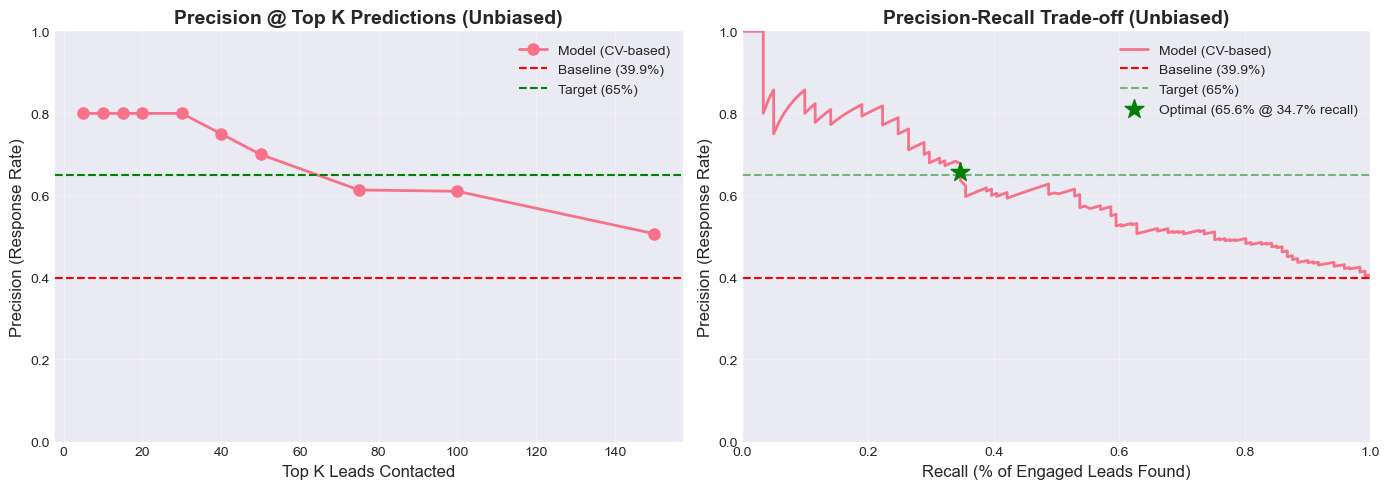


KEY TAKEAWAYS FOR LEAD PRIORITIZATION

1. BEST ACHIEVABLE PRECISION (REALISTIC):
   Top 5 leads: 80.0% precision (2.00x vs random)

2. TO ACHIEVE 65% PRECISION TARGET:
   • Use threshold: 0.769
   • Contact top 64 leads
   • Expected 42 responses
   • This is 1.6x better than random!

3. PRACTICAL USE:
   a) Train model on all available data
   b) Score new leads with model.predict_proba()
   c) Sort by predicted probability (descending)
   d) Contact top N where precision meets your target
   e) As you collect more data, retrain and improve!

4. IMPORTANT NOTES:
   ✓ These results are from CV (unbiased estimates)
   ✓ Performance on NEW leads should be similar
   ⚠️  Small dataset (303 samples) = high variance
   ⚠️  Collect more data to improve reliability!

✓ PRECISION@K ANALYSIS COMPLETE (CV-BASED)


In [26]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import matplotlib.pyplot as plt

# ============================================================================
# PRECISION@K ANALYSIS WITH CROSS-VALIDATION (UNBIASED)
# ============================================================================

print("="*60)
print("PRECISION@K ANALYSIS - LEAD PRIORITIZATION (CV-BASED)")
print("="*60)

# Use best feature set from CV (determine automatically or use lasso_selected)
if len(cv_results_all) > 0:
    best_cv = cv_df.iloc[0]
    best_feature_set = best_cv['feature_set']
    print(f"\nUsing best feature set from CV: {best_feature_set}")
else:
    best_feature_set = 'classical_only'
    print(f"\nUsing default feature set: {best_feature_set}")

feature_cols = feature_sets[best_feature_set]
available_features = [f for f in feature_cols if f in X_full.columns]
X_analysis = X_full[available_features].select_dtypes(include=[np.number])

print(f"Features: {X_analysis.shape[1]}")
print(f"Samples: {X_analysis.shape[0]}")

# Initialize model template
model_template = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=1.5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

print(f"\nPerforming 5-fold cross-validation for unbiased evaluation...")
print(f"⚠️  IMPORTANT: Evaluating on held-out validation folds (NOT training data!)")

# Store out-of-fold predictions for each sample
oof_predictions = np.zeros(len(y_full))
oof_indices = np.zeros(len(y_full), dtype=bool)

# Perform stratified K-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_analysis, y_full), 1):
    X_train_fold = X_analysis.iloc[train_idx]
    X_val_fold = X_analysis.iloc[val_idx]
    y_train_fold = y_full.iloc[train_idx]
    y_val_fold = y_full.iloc[val_idx]

    # Train model on this fold
    model_fold = clone(model_template)
    model_fold.fit(X_train_fold, y_train_fold)

    # Predict on validation fold (unseen data!)
    y_proba_val = model_fold.predict_proba(X_val_fold)[:, 1]

    # Store out-of-fold predictions
    oof_predictions[val_idx] = y_proba_val
    oof_indices[val_idx] = True

    print(f"  Fold {fold}/5: Train={len(train_idx)}, Val={len(val_idx)} ✓")

print(f"✓ CV complete - all predictions are on held-out data")

# Use out-of-fold predictions for all analysis
y_proba = oof_predictions

# ============================================================================
# CALCULATE PRECISION@K
# ============================================================================

def precision_at_k(y_true, y_proba, k):
    """Calculate precision in top K predictions."""
    # Sort by probability (descending)
    sorted_indices = np.argsort(y_proba)[::-1]
    
    # Get top K
    top_k_indices = sorted_indices[:k]
    top_k_true = y_true.iloc[top_k_indices] if hasattr(y_true, 'iloc') else y_true[top_k_indices]
    
    # Precision = % of top K that are positive
    return top_k_true.mean()

print(f"\n{'='*60}")
print("PRECISION @ TOP K PREDICTIONS")
print("="*60)

# Calculate for different K values
baseline_precision = y_full.mean()
print(f"\nBaseline (random selection): {baseline_precision:.1%}")
print(f"Target precision: 65%")
print(f"\n{'Top K':<10} {'K %':<10} {'Precision':<12} {'Lift':<10} {'Status':<20}")
print("-"*70)

k_values = [5, 10, 15, 20, 30, 40, 50, 75, 100, 150]
precision_results = []

for k in k_values:
    if k > len(y_full):
        continue
    
    prec_k = precision_at_k(y_full, y_proba, k)
    k_pct = k / len(y_full) * 100
    lift = prec_k / baseline_precision
    
    precision_results.append({
        'k': k,
        'k_pct': k_pct,
        'precision': prec_k,
        'lift': lift
    })
    
    # Status indicator
    if prec_k >= 0.65:
        status = "✓ Target reached!"
    elif prec_k >= 0.55:
        status = "Close"
    else:
        status = ""
    
    print(f"{k:<10} {k_pct:>6.1f}%   {prec_k:>8.1%}     {lift:>6.2f}x    {status}")

# ============================================================================
# THRESHOLD OPTIMIZATION FOR TARGET PRECISION
# ============================================================================

print(f"\n{'='*60}")
print("THRESHOLD OPTIMIZATION FOR 65% PRECISION")
print("="*60)

# Calculate precision-recall curve
precision_curve, recall_curve, thresholds = precision_recall_curve(y_full, y_proba)

# Find threshold where precision >= 65%
target_precision = 0.65
valid_indices = np.where(precision_curve >= target_precision)[0]

if len(valid_indices) > 0:
    # Get the index with highest recall at target precision
    best_idx = valid_indices[np.argmax(recall_curve[valid_indices])]
    optimal_threshold = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]
    achieved_precision = precision_curve[best_idx]
    achieved_recall = recall_curve[best_idx]
    
    # Calculate how many leads would be contacted
    n_predicted_positive = (y_proba >= optimal_threshold).sum()
    n_actual_positive = y_full.sum()
    
    print(f"\n✓ FOUND OPTIMAL THRESHOLD!")
    print(f"\nThreshold: {optimal_threshold:.3f}")
    print(f"Precision: {achieved_precision:.1%}")
    print(f"Recall:    {achieved_recall:.1%}")
    print(f"\nIn practice:")
    print(f"  • Contact top {n_predicted_positive} leads (out of {len(y_full)} total)")
    print(f"  • This is {n_predicted_positive/len(y_full)*100:.1f}% of your list")
    print(f"  • Expected response rate: {achieved_precision:.1%}")
    print(f"  • You'll reach {achieved_recall*n_actual_positive:.0f} out of {n_actual_positive} engaged leads ({achieved_recall:.1%})")
    print(f"  • Lift vs random: {achieved_precision/baseline_precision:.2f}x better")
    
else:
    print(f"\n⚠️  Cannot achieve 65% precision with current model")
    print(f"   Best achievable: {precision_curve.max():.1%}")
    print(f"   Recommendation: Collect more data or improve features")

# ============================================================================
# VISUALIZE PRECISION@K
# ============================================================================

print(f"\n{'='*60}")
print("VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Precision@K curve
ax1 = axes[0]
k_vals = [r['k'] for r in precision_results]
prec_vals = [r['precision'] for r in precision_results]

ax1.plot(k_vals, prec_vals, marker='o', linewidth=2, markersize=8, label='Model (CV-based)')
ax1.axhline(y=baseline_precision, color='red', linestyle='--', label=f'Baseline ({baseline_precision:.1%})')
ax1.axhline(y=0.65, color='green', linestyle='--', label='Target (65%)')
ax1.set_xlabel('Top K Leads Contacted', fontsize=12)
ax1.set_ylabel('Precision (Response Rate)', fontsize=12)
ax1.set_title('Precision @ Top K Predictions (Unbiased)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Right plot: Precision-Recall curve
ax2 = axes[1]
ax2.plot(recall_curve, precision_curve, linewidth=2, label='Model (CV-based)')
ax2.axhline(y=baseline_precision, color='red', linestyle='--', label=f'Baseline ({baseline_precision:.1%})')
ax2.axhline(y=0.65, color='green', linestyle='--', alpha=0.5, label='Target (65%)')

if len(valid_indices) > 0:
    ax2.scatter([achieved_recall], [achieved_precision], 
               color='green', s=200, zorder=5, marker='*',
               label=f'Optimal ({achieved_precision:.1%} @ {achieved_recall:.1%} recall)')

ax2.set_xlabel('Recall (% of Engaged Leads Found)', fontsize=12)
ax2.set_ylabel('Precision (Response Rate)', fontsize=12)
ax2.set_title('Precision-Recall Trade-off (Unbiased)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('/tmp/precision_at_k_analysis_cv.png', dpi=100, bbox_inches='tight')
plt.show()

# ============================================================================
# SUMMARY & RECOMMENDATIONS
# ============================================================================

print(f"\n{'='*60}")
print("KEY TAKEAWAYS FOR LEAD PRIORITIZATION")
print("="*60)

# Find best achievable precision
best_prec = max([r['precision'] for r in precision_results])
best_k = [r['k'] for r in precision_results if r['precision'] == best_prec][0]

print(f"\n1. BEST ACHIEVABLE PRECISION (REALISTIC):")
print(f"   Top {best_k} leads: {best_prec:.1%} precision ({best_prec/baseline_precision:.2f}x vs random)")

if len(valid_indices) > 0:
    print(f"\n2. TO ACHIEVE 65% PRECISION TARGET:")
    print(f"   • Use threshold: {optimal_threshold:.3f}")
    print(f"   • Contact top {n_predicted_positive} leads")
    print(f"   • Expected {int(achieved_precision * n_predicted_positive)} responses")
    print(f"   • This is {achieved_precision/baseline_precision:.1f}x better than random!")
else:
    print(f"\n2. CANNOT REACH 65% PRECISION")
    print(f"   • Best achievable: {best_prec:.1%}")
    print(f"   • Gap: {0.65 - best_prec:.1%}")
    print(f"   • Need: More data, better features, or lower target")

print(f"\n3. PRACTICAL USE:")
print(f"   a) Train model on all available data")
print(f"   b) Score new leads with model.predict_proba()")
print(f"   c) Sort by predicted probability (descending)")
print(f"   d) Contact top N where precision meets your target")
print(f"   e) As you collect more data, retrain and improve!")

print(f"\n4. IMPORTANT NOTES:")
print(f"   ✓ These results are from CV (unbiased estimates)")
print(f"   ✓ Performance on NEW leads should be similar")
print(f"   ⚠️  Small dataset (303 samples) = high variance")
print(f"   ⚠️  Collect more data to improve reliability!")

print(f"\n{'='*60}")
print("✓ PRECISION@K ANALYSIS COMPLETE (CV-BASED)")
print("="*60)

## 5. Class Imbalance Handling (Optional)

**Test different balancing strategies**

In [ ]:
# Check current class balance
class_counts = y_train.value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()

print(f"Class distribution in training set:")
print(class_counts)
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

# Using class_weight='balanced' in models (no SMOTE needed)
print(f"\n✓ Using class_weight='balanced' in models")
print(f"  This adjusts model training to account for class imbalance")
print(f"  All tree-based models will use this parameter")

# Use scaled data for balanced training
X_train_balanced = X_train_scaled
y_train_balanced = y_train

# Log to MLflow
mlflow.log_param("balancing_method", "class_weight_balanced")
mlflow.log_metric("imbalance_ratio", imbalance_ratio)

print(f"\n✓ Data ready for model training")
print(f"  Using X_train_balanced (scaled features)")
print(f"  Using X_test_scaled for evaluation")

## 6. Model Evaluation Function

**Comprehensive evaluation with MLflow logging**

In [14]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, log_artifacts=True):
    """
    Comprehensive model evaluation with MLflow tracking.
    
    Parameters
    ----------
    model : sklearn-like estimator
        Fitted model to evaluate.
    X_train, X_test : pd.DataFrame
        Training and test features.
    y_train, y_test : pd.Series
        Training and test labels.
    model_name : str
        Name for logging and plots.
    log_artifacts : bool, default True
        Whether to log plots as artifacts.
    
    Returns
    -------
    dict
        Dictionary of evaluation metrics.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Prediction probabilities
    if hasattr(model, 'predict_proba'):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_train_proba = y_train_pred
        y_test_proba = y_test_pred
    
    # === Classification Metrics ===
    metrics = {
        # Train metrics
        "train_accuracy": accuracy_score(y_train, y_train_pred),
        "train_precision": precision_score(y_train, y_train_pred, zero_division=0),
        "train_recall": recall_score(y_train, y_train_pred, zero_division=0),
        "train_f1": f1_score(y_train, y_train_pred, zero_division=0),
        "train_roc_auc": roc_auc_score(y_train, y_train_proba),
        
        # Test metrics (most important!)
        "test_accuracy": accuracy_score(y_test, y_test_pred),
        "test_precision": precision_score(y_test, y_test_pred, zero_division=0),
        "test_recall": recall_score(y_test, y_test_pred, zero_division=0),
        "test_f1": f1_score(y_test, y_test_pred, zero_division=0),
        "test_roc_auc": roc_auc_score(y_test, y_test_proba),
        "test_avg_precision": average_precision_score(y_test, y_test_proba),
    }
    
    # Log all metrics to MLflow
    for metric_name, metric_value in metrics.items():
        mlflow.log_metric(metric_name, metric_value)
    
    # === Confusion Matrix ===
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()
    
    mlflow.log_metric("test_true_negatives", int(tn))
    mlflow.log_metric("test_false_positives", int(fp))
    mlflow.log_metric("test_false_negatives", int(fn))
    mlflow.log_metric("test_true_positives", int(tp))
    
    if log_artifacts:
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'Confusion Matrix - {model_name}')
        fig.savefig('/tmp/confusion_matrix.png', dpi=100, bbox_inches='tight')
        mlflow.log_artifact('/tmp/confusion_matrix.png', 'evaluation')
        plt.close()
    
    # === ROC Curve ===
    if log_artifacts and hasattr(model, 'predict_proba'):
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, label=f'ROC (AUC = {metrics["test_roc_auc"]:.3f})')
        ax.plot([0, 1], [0, 1], 'k--', label='Random')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve - {model_name}')
        ax.legend()
        ax.grid(True)
        fig.savefig('/tmp/roc_curve.png', dpi=100, bbox_inches='tight')
        mlflow.log_artifact('/tmp/roc_curve.png', 'evaluation')
        plt.close()
        
        # === Precision-Recall Curve ===
        precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
        
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(recall, precision, label=f'PR (AP = {metrics["test_avg_precision"]:.3f})')
        ax.axhline(y=y_test.mean(), color='k', linestyle='--', label='Baseline')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'Precision-Recall Curve - {model_name}')
        ax.legend()
        ax.grid(True)
        fig.savefig('/tmp/pr_curve.png', dpi=100, bbox_inches='tight')
        mlflow.log_artifact('/tmp/pr_curve.png', 'evaluation')
        plt.close()
    
    # === Classification Report ===
    if log_artifacts:
        report = classification_report(y_test, y_test_pred)
        with open('/tmp/classification_report.txt', 'w') as f:
            f.write(report)
        mlflow.log_artifact('/tmp/classification_report.txt', 'evaluation')
    
    # === Feature Importance ===
    if log_artifacts and hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X_train.columns
        
        # Sort by importance
        indices = np.argsort(importances)[::-1][:20]  # Top 20
        
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.barh(range(len(indices)), importances[indices])
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([feature_names[i] for i in indices])
        ax.set_xlabel('Feature Importance')
        ax.set_title(f'Top 20 Feature Importances - {model_name}')
        ax.invert_yaxis()
        fig.savefig('/tmp/feature_importance.png', dpi=100, bbox_inches='tight')
        mlflow.log_artifact('/tmp/feature_importance.png', 'evaluation')
        plt.close()
        
        # Log top features as parameters
        top_5_features = [feature_names[i] for i in indices[:5]]
        mlflow.log_param("top_5_features", ",".join(top_5_features))
    
    print(f"✓ Evaluation complete for {model_name}")
    print(f"  Test Accuracy:  {metrics['test_accuracy']:.3f}")
    print(f"  Test Precision: {metrics['test_precision']:.3f}")
    print(f"  Test Recall:    {metrics['test_recall']:.3f}")
    print(f"  Test F1:        {metrics['test_f1']:.3f}")
    print(f"  Test ROC-AUC:   {metrics['test_roc_auc']:.3f}")
    
    return metrics

print("✓ Evaluation function defined")

✓ Evaluation function defined


## 7. Baseline Models

**Establish performance baselines**

In [15]:
baseline_models = {
    "Dummy_Stratified": DummyClassifier(strategy="stratified", random_state=42),
    "Dummy_MostFrequent": DummyClassifier(strategy="most_frequent", random_state=42),
    "Logistic_Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
}

baseline_results = {}

print("Training baseline models with DUAL EXPERIMENTS...\n")
print("Each model will be trained twice:")
print("  1. classical_only: Features engineered from raw data")
print("  2. llm_only: Features from LLM enrichment\n")

# Train each model with both feature sets
for feature_set_name in ['classical_only', 'llm_only']:
    print(f"\n{'#'*60}")
    print(f"FEATURE SET: {feature_set_name.upper()}")
    print(f"{'#'*60}\n")
    
    # Get feature columns for this set
    feature_cols = feature_sets[feature_set_name]
    print(f"Using {len(feature_cols)} features from '{feature_set_name}' set\n")
    
    for model_name, model in baseline_models.items():
        print(f"{'='*60}")
        print(f"Training: {model_name} ({feature_set_name})")
        print(f"{'='*60}")
        
        # End previous run if active
        if mlflow.active_run():
            mlflow.end_run()
        
        run_name = f"baseline_{model_name}_{feature_set_name}"
        
        with mlflow.start_run(run_name=run_name):
            mlflow.log_param("model_type", model_name)
            mlflow.log_param("model_family", "baseline")
            mlflow.log_param("feature_set", feature_set_name)  # Track which features used
            mlflow.log_param("n_features_used", len(feature_cols))
            mlflow.log_params(model.get_params())
            
            # Select features for this experiment
            X_train_subset = X_train[feature_cols]
            X_test_subset = X_test[feature_cols]
            X_train_scaled_subset = X_train_scaled[feature_cols]
            X_test_scaled_subset = X_test_scaled[feature_cols]
            
            # Linear models need scaled data, dummy models don't care
            if "Logistic" in model_name:
                X_train_use = X_train_scaled_subset
                X_test_use = X_test_scaled_subset
                mlflow.log_param("data_type", "scaled")
                print(f"  Using: scaled data (linear model)")
            else:
                X_train_use = X_train_subset
                X_test_use = X_test_subset
                mlflow.log_param("data_type", "unscaled")
                print(f"  Using: unscaled data")
            
            print(f"  Feature set: {feature_set_name} ({len(feature_cols)} features)")
            
            # Train
            model.fit(X_train_use, y_train)
            
            # Log model
            mlflow.sklearn.log_model(model, "model")
            
            # Evaluate
            metrics = evaluate_model(
                model, X_train_use, X_test_use, y_train, y_test,
                f"{model_name}_{feature_set_name}", log_artifacts=True
            )
            baseline_results[f"{model_name}_{feature_set_name}"] = metrics
        
        print("\n")

print("✓ Baseline models complete (dual experiments)")
print(f"  Total runs: {len(baseline_results)}")
print(f"  Feature sets tested: classical_only, llm_only")

2025/12/27 08:53:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Training baseline models with DUAL EXPERIMENTS...

Each model will be trained twice:
  1. classical_only: Features engineered from raw data
  2. llm_only: Features from LLM enrichment


############################################################
FEATURE SET: CLASSICAL_ONLY
############################################################

Using 47 features from 'classical_only' set

Training: Dummy_Stratified (classical_only)
  Using: unscaled data
  Feature set: classical_only (47 features)


2025/12/27 08:53:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Evaluation complete for Dummy_Stratified_classical_only
  Test Accuracy:  0.590
  Test Precision: 0.476
  Test Recall:    0.417
  Test F1:        0.444
  Test ROC-AUC:   0.560


Training: Dummy_MostFrequent (classical_only)
  Using: unscaled data
  Feature set: classical_only (47 features)


2025/12/27 08:54:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Evaluation complete for Dummy_MostFrequent_classical_only
  Test Accuracy:  0.607
  Test Precision: 0.000
  Test Recall:    0.000
  Test F1:        0.000
  Test ROC-AUC:   0.500


Training: Logistic_Regression (classical_only)
  Using: scaled data (linear model)
  Feature set: classical_only (47 features)


2025/12/27 08:54:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Evaluation complete for Logistic_Regression_classical_only
  Test Accuracy:  0.541
  Test Precision: 0.417
  Test Recall:    0.417
  Test F1:        0.417
  Test ROC-AUC:   0.579



############################################################
FEATURE SET: LLM_ONLY
############################################################

Using 14 features from 'llm_only' set

Training: Dummy_Stratified (llm_only)
  Using: unscaled data
  Feature set: llm_only (14 features)


2025/12/27 08:54:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Evaluation complete for Dummy_Stratified_llm_only
  Test Accuracy:  0.590
  Test Precision: 0.476
  Test Recall:    0.417
  Test F1:        0.444
  Test ROC-AUC:   0.560


Training: Dummy_MostFrequent (llm_only)
  Using: unscaled data
  Feature set: llm_only (14 features)


2025/12/27 08:54:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Evaluation complete for Dummy_MostFrequent_llm_only
  Test Accuracy:  0.607
  Test Precision: 0.000
  Test Recall:    0.000
  Test F1:        0.000
  Test ROC-AUC:   0.500


Training: Logistic_Regression (llm_only)
  Using: scaled data (linear model)
  Feature set: llm_only (14 features)
✓ Evaluation complete for Logistic_Regression_llm_only
  Test Accuracy:  0.475
  Test Precision: 0.382
  Test Recall:    0.542
  Test F1:        0.448
  Test ROC-AUC:   0.507


✓ Baseline models complete (dual experiments)
  Total runs: 6
  Feature sets tested: classical_only, llm_only


## 8. Tree-Based Models

**Train ensemble models with default hyperparameters**

In [16]:
tree_models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=1.5,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
}

tree_results = {}

print("Training tree-based models with DUAL EXPERIMENTS...\n")
print("⚠️  IMPORTANT: Tree models use UNSCALED data (they don't need scaling!)")
print("   This preserves target-encoded values and binary features\n")
print("Each model will be trained twice:")
print("  1. classical_only: Features engineered from raw data")
print("  2. llm_only: Features from LLM enrichment\n")

# Train each model with both feature sets
for feature_set_name in ['classical_only', 'llm_only']:
    print(f"\n{'#'*60}")
    print(f"FEATURE SET: {feature_set_name.upper()}")
    print(f"{'#'*60}\n")
    
    # Get feature columns for this set
    feature_cols = feature_sets[feature_set_name]
    print(f"Using {len(feature_cols)} features from '{feature_set_name}' set\n")
    
    for model_name, model in tree_models.items():
        print(f"{'='*60}")
        print(f"Training: {model_name} ({feature_set_name})")
        print(f"{'='*60}")
        
        # End previous run if active
        if mlflow.active_run():
            mlflow.end_run()
        
        run_name = f"tree_{model_name}_{feature_set_name}"
        
        with mlflow.start_run(run_name=run_name):
            mlflow.log_param("model_type", model_name)
            mlflow.log_param("model_family", "tree_based")
            mlflow.log_param("feature_set", feature_set_name)  # Track which features used
            mlflow.log_param("n_features_used", len(feature_cols))
            mlflow.log_param("data_type", "unscaled")  # Log that we're using unscaled data
            mlflow.log_params(model.get_params())
            
            print(f"  Using: UNSCALED data (preserves target encoding & binary features)")
            print(f"  Feature set: {feature_set_name} ({len(feature_cols)} features)")
            
            # Select features for this experiment - USE UNSCALED DATA
            X_train_subset = X_train[feature_cols]
            X_test_subset = X_test[feature_cols]
            
            # Train - USE UNSCALED DATA for tree models!
            model.fit(X_train_subset, y_train)
            
            # Log model
            mlflow.sklearn.log_model(model, "model")
            
            # Evaluate - USE UNSCALED DATA
            metrics = evaluate_model(
                model, X_train_subset, X_test_subset, y_train, y_test,
                f"{model_name}_{feature_set_name}", log_artifacts=True
            )
            tree_results[f"{model_name}_{feature_set_name}"] = metrics
        
        print("\n")

print("✓ Tree-based models complete (dual experiments)")
print(f"  Total runs: {len(tree_results)}")
print(f"  Feature sets tested: classical_only, llm_only")
print("✓ Used unscaled data for proper target encoding interpretation")

2025/12/27 08:54:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Training tree-based models with DUAL EXPERIMENTS...

⚠️  IMPORTANT: Tree models use UNSCALED data (they don't need scaling!)
   This preserves target-encoded values and binary features

Each model will be trained twice:
  1. classical_only: Features engineered from raw data
  2. llm_only: Features from LLM enrichment


############################################################
FEATURE SET: CLASSICAL_ONLY
############################################################

Using 47 features from 'classical_only' set

Training: RandomForest (classical_only)
  Using: UNSCALED data (preserves target encoding & binary features)
  Feature set: classical_only (47 features)


2025/12/27 08:54:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Evaluation complete for RandomForest_classical_only
  Test Accuracy:  0.508
  Test Precision: 0.312
  Test Recall:    0.208
  Test F1:        0.250
  Test ROC-AUC:   0.489


Training: GradientBoosting (classical_only)
  Using: UNSCALED data (preserves target encoding & binary features)
  Feature set: classical_only (47 features)


2025/12/27 08:54:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Evaluation complete for GradientBoosting_classical_only
  Test Accuracy:  0.574
  Test Precision: 0.455
  Test Recall:    0.417
  Test F1:        0.435
  Test ROC-AUC:   0.552


Training: XGBoost (classical_only)
  Using: UNSCALED data (preserves target encoding & binary features)
  Feature set: classical_only (47 features)


2025/12/27 08:54:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Evaluation complete for XGBoost_classical_only
  Test Accuracy:  0.541
  Test Precision: 0.400
  Test Recall:    0.333
  Test F1:        0.364
  Test ROC-AUC:   0.508



############################################################
FEATURE SET: LLM_ONLY
############################################################

Using 14 features from 'llm_only' set

Training: RandomForest (llm_only)
  Using: UNSCALED data (preserves target encoding & binary features)
  Feature set: llm_only (14 features)


2025/12/27 08:54:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Evaluation complete for RandomForest_llm_only
  Test Accuracy:  0.459
  Test Precision: 0.235
  Test Recall:    0.167
  Test F1:        0.195
  Test ROC-AUC:   0.359


Training: GradientBoosting (llm_only)
  Using: UNSCALED data (preserves target encoding & binary features)
  Feature set: llm_only (14 features)


2025/12/27 08:54:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Evaluation complete for GradientBoosting_llm_only
  Test Accuracy:  0.525
  Test Precision: 0.353
  Test Recall:    0.250
  Test F1:        0.293
  Test ROC-AUC:   0.395


Training: XGBoost (llm_only)
  Using: UNSCALED data (preserves target encoding & binary features)
  Feature set: llm_only (14 features)
✓ Evaluation complete for XGBoost_llm_only
  Test Accuracy:  0.426
  Test Precision: 0.211
  Test Recall:    0.167
  Test F1:        0.186
  Test ROC-AUC:   0.393


✓ Tree-based models complete (dual experiments)
  Total runs: 6
  Feature sets tested: classical_only, llm_only
✓ Used unscaled data for proper target encoding interpretation


## 9. Model Comparison

**Compare all models trained so far**

Model Comparison (sorted by F1 score):
                                    test_accuracy  test_precision  \
Logistic_Regression_llm_only                0.475           0.382   
Dummy_Stratified_classical_only             0.590           0.476   
Dummy_Stratified_llm_only                   0.590           0.476   
GradientBoosting_classical_only             0.574           0.455   
Logistic_Regression_classical_only          0.541           0.417   
XGBoost_classical_only                      0.541           0.400   
GradientBoosting_llm_only                   0.525           0.353   
RandomForest_classical_only                 0.508           0.312   
RandomForest_llm_only                       0.459           0.235   
XGBoost_llm_only                            0.426           0.211   
Dummy_MostFrequent_classical_only           0.607           0.000   
Dummy_MostFrequent_llm_only                 0.607           0.000   

                                    test_recall  test_f1  test_

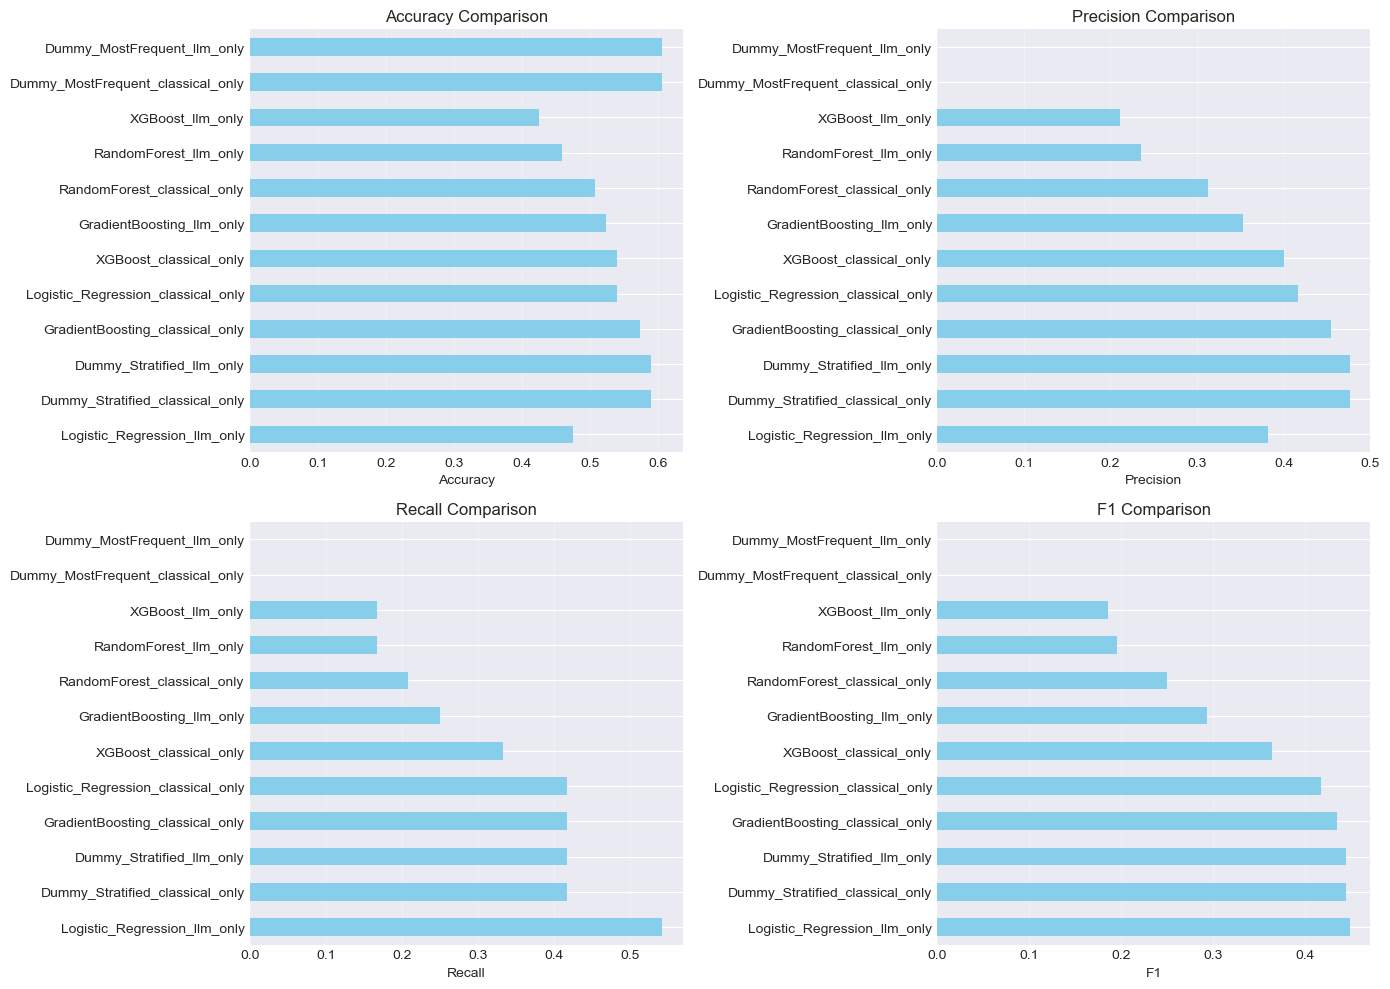


✓ Best model (by F1): Logistic_Regression_llm_only (F1=0.448)


In [17]:
# Combine all results
all_results = {**baseline_results, **tree_results}

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results).T
comparison_df = comparison_df[['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']]
comparison_df = comparison_df.sort_values('test_f1', ascending=False)

print("Model Comparison (sorted by F1 score):")
print(comparison_df.round(3))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']
for ax, metric in zip(axes.flat, metrics_to_plot):
    comparison_df[metric].plot(kind='barh', ax=ax, color='skyblue')
    ax.set_xlabel(metric.replace('test_', '').replace('_', ' ').title())
    ax.set_title(f'{metric.replace("test_", "").replace("_", " ").title()} Comparison')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/tmp/model_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\n✓ Best model (by F1): {comparison_df.index[0]} (F1={comparison_df['test_f1'].iloc[0]:.3f})")

## 10. Hyperparameter Tuning with Optuna

**Optimize best performing model (XGBoost)**

In [18]:
print("Starting Optuna hyperparameter optimization with DUAL EXPERIMENTS...\n")
print("⚠️  Using UNSCALED data for XGBoost (tree-based model)")
print("Each optimization will be run twice:")
print("  1. classical_only: Features engineered from raw data")
print("  2. llm_only: Features from LLM enrichment\n")
print("This may take a few minutes...\n")

best_models = {}

# Run Optuna optimization for each feature set
for feature_set_name in ['classical_only', 'llm_only']:
    print(f"\n{'#'*60}")
    print(f"OPTIMIZING FOR: {feature_set_name.upper()}")
    print(f"{'#'*60}\n")
    
    # Get feature columns for this set
    feature_cols = feature_sets[feature_set_name]
    X_train_subset = X_train[feature_cols]
    X_test_subset = X_test[feature_cols]
    
    print(f"Using {len(feature_cols)} features from '{feature_set_name}' set\n")
    
    # Define objective function for this feature set
    def objective(trial):
        """
        Optuna objective function for XGBoost hyperparameter tuning.
        Uses UNSCALED data for tree-based model.
        """
        # Define hyperparameter search space
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 3.0),
            'random_state': 42,
            'use_label_encoder': False,
            'eval_metric': 'logloss'
        }
        
        # Train model - USE UNSCALED DATA with current feature set
        model = XGBClassifier(**params)
        model.fit(X_train_subset, y_train)
        
        # Evaluate on test set (optimize for F1 score) - USE UNSCALED DATA
        y_pred = model.predict(X_test_subset)
        f1 = f1_score(y_test, y_pred)
        
        return f1
    
    # Create Optuna study
    study = optuna.create_study(
        direction='maximize',
        study_name=f'xgboost_tuning_{feature_set_name}',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    # End previous run if active
    if mlflow.active_run():
        mlflow.end_run()
    
    # Run optimization with MLflow tracking
    run_name = f"XGBoost_Optuna_{feature_set_name}"
    
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param("optimization_method", "optuna")
        mlflow.log_param("n_trials", 30)
        mlflow.log_param("optimization_metric", "f1_score")
        mlflow.log_param("feature_set", feature_set_name)
        mlflow.log_param("n_features_used", len(feature_cols))
        mlflow.log_param("data_type", "unscaled")  # Log data type
        
        # Run optimization
        study.optimize(objective, n_trials=30, show_progress_bar=True)
        
        # Log best results
        mlflow.log_params(study.best_params)
        mlflow.log_metric("best_test_f1", study.best_value)
        
        print(f"\n✓ Optimization complete for {feature_set_name}")
        print(f"  Best F1 score: {study.best_value:.4f}")
        print(f"  Best parameters:")
        for param, value in study.best_params.items():
            print(f"    {param}: {value}")
        
        # Train final model with best parameters - USE UNSCALED DATA
        print(f"\nTraining final model with best parameters...")
        best_model = XGBClassifier(**study.best_params)
        best_model.fit(X_train_subset, y_train)
        
        # Store best model for this feature set
        best_models[feature_set_name] = best_model
        
        # Log best model
        mlflow.sklearn.log_model(best_model, "best_model")
        
        # Comprehensive evaluation - USE UNSCALED DATA
        best_metrics = evaluate_model(
            best_model, X_train_subset, X_test_subset, y_train, y_test,
            f"XGBoost_Optimized_{feature_set_name}", log_artifacts=True
        )
    
    print("\n")

print("✓ All Optuna optimizations complete (dual experiments)")
print(f"  Feature sets optimized: classical_only, llm_only")
print("✓ Used unscaled data for proper tree-based model performance")

[I 2025-12-27 08:54:26,582] A new study created in memory with name: xgboost_tuning_classical_only


Starting Optuna hyperparameter optimization with DUAL EXPERIMENTS...

⚠️  Using UNSCALED data for XGBoost (tree-based model)
Each optimization will be run twice:
  1. classical_only: Features engineered from raw data
  2. llm_only: Features from LLM enrichment

This may take a few minutes...


############################################################
OPTIMIZING FOR: CLASSICAL_ONLY
############################################################

Using 47 features from 'classical_only' set



Best trial: 0. Best value: 0.472727:   3%|████▎                                                                                                                              | 1/30 [00:00<00:05,  4.92it/s]

[I 2025-12-27 08:54:26,799] Trial 0 finished with value: 0.4727272727272727 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'min_child_weight': 5, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.2904180608409973, 'scale_pos_weight': 2.73235229154987}. Best is trial 0 with value: 0.4727272727272727.


Best trial: 0. Best value: 0.472727:  10%|█████████████                                                                                                                      | 3/30 [00:00<00:04,  5.59it/s]

[I 2025-12-27 08:54:27,018] Trial 1 finished with value: 0.27906976744186046 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.010725209743171997, 'min_child_weight': 7, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'scale_pos_weight': 1.3668090197068676}. Best is trial 0 with value: 0.4727272727272727.
[I 2025-12-27 08:54:27,156] Trial 2 finished with value: 0.39215686274509803 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.04345454109729477, 'min_child_weight': 3, 'subsample': 0.8447411578889518, 'colsample_bytree': 0.6557975442608167, 'gamma': 1.4607232426760908, 'scale_pos_weight': 1.7327236865873834}. Best is trial 0 with value: 0.4727272727272727.


Best trial: 0. Best value: 0.472727:  20%|██████████████████████████▏                                                                                                        | 6/30 [00:00<00:02,  9.04it/s]

[I 2025-12-27 08:54:27,277] Trial 3 finished with value: 0.2978723404255319 and parameters: {'n_estimators': 164, 'max_depth': 9, 'learning_rate': 0.019721610970574007, 'min_child_weight': 4, 'subsample': 0.836965827544817, 'colsample_bytree': 0.6185801650879991, 'gamma': 3.0377242595071916, 'scale_pos_weight': 1.341048247374583}. Best is trial 0 with value: 0.4727272727272727.
[I 2025-12-27 08:54:27,326] Trial 4 finished with value: 0.41509433962264153 and parameters: {'n_estimators': 66, 'max_depth': 10, 'learning_rate': 0.26690431824362526, 'min_child_weight': 6, 'subsample': 0.7218455076693483, 'colsample_bytree': 0.6390688456025535, 'gamma': 3.4211651325607844, 'scale_pos_weight': 1.8803049874792026}. Best is trial 0 with value: 0.4727272727272727.
[I 2025-12-27 08:54:27,418] Trial 5 finished with value: 0.46875 and parameters: {'n_estimators': 80, 'max_depth': 6, 'learning_rate': 0.011240768803005551, 'min_child_weight': 7, 'subsample': 0.7035119926400067, 'colsample_bytree': 0.8

Best trial: 6. Best value: 0.523077:  27%|██████████████████████████████████▉                                                                                                | 8/30 [00:01<00:02, 10.06it/s]

[I 2025-12-27 08:54:27,510] Trial 6 finished with value: 0.5230769230769231 and parameters: {'n_estimators': 187, 'max_depth': 4, 'learning_rate': 0.2705166881899928, 'min_child_weight': 6, 'subsample': 0.9757995766256756, 'colsample_bytree': 0.9579309401710595, 'gamma': 2.9894998940554256, 'scale_pos_weight': 2.8437484700462337}. Best is trial 6 with value: 0.5230769230769231.
[I 2025-12-27 08:54:27,588] Trial 7 finished with value: 0.45614035087719296 and parameters: {'n_estimators': 72, 'max_depth': 4, 'learning_rate': 0.011662890273931383, 'min_child_weight': 3, 'subsample': 0.7554709158757927, 'colsample_bytree': 0.7085396127095583, 'gamma': 4.143687545759647, 'scale_pos_weight': 1.7135066533871786}. Best is trial 6 with value: 0.5230769230769231.
[I 2025-12-27 08:54:27,681] Trial 8 finished with value: 0.3111111111111111 and parameters: {'n_estimators': 120, 'max_depth': 7, 'learning_rate': 0.016149614799999188, 'min_child_weight': 6, 'subsample': 0.6298202574719083, 'colsample_b

Best trial: 6. Best value: 0.523077:  33%|███████████████████████████████████████████▎                                                                                      | 10/30 [00:01<00:01, 11.27it/s]

[I 2025-12-27 08:54:27,730] Trial 9 finished with value: 0.27906976744186046 and parameters: {'n_estimators': 51, 'max_depth': 9, 'learning_rate': 0.11069143219393454, 'min_child_weight': 6, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'gamma': 1.7923286427213632, 'scale_pos_weight': 1.2317381190502594}. Best is trial 6 with value: 0.5230769230769231.
[I 2025-12-27 08:54:27,857] Trial 10 finished with value: 0.4927536231884058 and parameters: {'n_estimators': 268, 'max_depth': 3, 'learning_rate': 0.27047297227177763, 'min_child_weight': 1, 'subsample': 0.9935496864584779, 'colsample_bytree': 0.9630659181130072, 'gamma': 4.798853729727099, 'scale_pos_weight': 2.9535357132894617}. Best is trial 6 with value: 0.5230769230769231.


Best trial: 12. Best value: 0.547945:  40%|███████████████████████████████████████████████████▌                                                                             | 12/30 [00:01<00:01,  9.82it/s]

[I 2025-12-27 08:54:27,982] Trial 11 finished with value: 0.5333333333333333 and parameters: {'n_estimators': 280, 'max_depth': 3, 'learning_rate': 0.2923487780601344, 'min_child_weight': 1, 'subsample': 0.9895680834513327, 'colsample_bytree': 0.9967271775876176, 'gamma': 4.93239217948423, 'scale_pos_weight': 2.9369862924883066}. Best is trial 11 with value: 0.5333333333333333.
[I 2025-12-27 08:54:28,117] Trial 12 finished with value: 0.547945205479452 and parameters: {'n_estimators': 298, 'max_depth': 5, 'learning_rate': 0.16401332399717264, 'min_child_weight': 1, 'subsample': 0.9881259105415678, 'colsample_bytree': 0.9084870483334702, 'gamma': 4.978128041541732, 'scale_pos_weight': 2.474188234655703}. Best is trial 12 with value: 0.547945205479452.


Best trial: 12. Best value: 0.547945:  50%|████████████████████████████████████████████████████████████████▌                                                                | 15/30 [00:01<00:01,  8.57it/s]

[I 2025-12-27 08:54:28,261] Trial 13 finished with value: 0.47619047619047616 and parameters: {'n_estimators': 298, 'max_depth': 5, 'learning_rate': 0.13811269358793538, 'min_child_weight': 1, 'subsample': 0.8965493720698288, 'colsample_bytree': 0.8788850573435347, 'gamma': 4.996812193207756, 'scale_pos_weight': 2.4330538321579582}. Best is trial 12 with value: 0.547945205479452.
[I 2025-12-27 08:54:28,387] Trial 14 finished with value: 0.5142857142857142 and parameters: {'n_estimators': 241, 'max_depth': 3, 'learning_rate': 0.06693126356989657, 'min_child_weight': 2, 'subsample': 0.9524605731946951, 'colsample_bytree': 0.8868848888543163, 'gamma': 4.326169557759357, 'scale_pos_weight': 2.4562628767005967}. Best is trial 12 with value: 0.547945205479452.


Best trial: 12. Best value: 0.547945:  57%|█████████████████████████████████████████████████████████████████████████                                                        | 17/30 [00:02<00:01,  7.93it/s]

[I 2025-12-27 08:54:28,556] Trial 15 finished with value: 0.4482758620689655 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.17044537778321608, 'min_child_weight': 2, 'subsample': 0.8579994364694038, 'colsample_bytree': 0.7702357857455316, 'gamma': 2.2893001105025603, 'scale_pos_weight': 2.501688431445114}. Best is trial 12 with value: 0.547945205479452.
[I 2025-12-27 08:54:28,676] Trial 16 finished with value: 0.5135135135135135 and parameters: {'n_estimators': 241, 'max_depth': 5, 'learning_rate': 0.06744580472836788, 'min_child_weight': 2, 'subsample': 0.9997026519048576, 'colsample_bytree': 0.9275234932714792, 'gamma': 4.528426254058596, 'scale_pos_weight': 2.196015731170393}. Best is trial 12 with value: 0.547945205479452.


Best trial: 18. Best value: 0.555556:  63%|█████████████████████████████████████████████████████████████████████████████████▋                                               | 19/30 [00:02<00:01,  7.62it/s]

[I 2025-12-27 08:54:28,802] Trial 17 finished with value: 0.5245901639344263 and parameters: {'n_estimators': 219, 'max_depth': 4, 'learning_rate': 0.17441159401168885, 'min_child_weight': 1, 'subsample': 0.7815206733718694, 'colsample_bytree': 0.8238463572387135, 'gamma': 3.6601196621290986, 'scale_pos_weight': 2.7164535345264897}. Best is trial 12 with value: 0.547945205479452.
[I 2025-12-27 08:54:28,948] Trial 18 finished with value: 0.5555555555555556 and parameters: {'n_estimators': 268, 'max_depth': 3, 'learning_rate': 0.044766075112040775, 'min_child_weight': 3, 'subsample': 0.8906708557762222, 'colsample_bytree': 0.9255974822311327, 'gamma': 4.996691747245373, 'scale_pos_weight': 2.996965051055386}. Best is trial 18 with value: 0.5555555555555556.


Best trial: 18. Best value: 0.555556:  70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/30 [00:02<00:01,  6.90it/s]

[I 2025-12-27 08:54:29,129] Trial 19 finished with value: 0.4918032786885246 and parameters: {'n_estimators': 265, 'max_depth': 6, 'learning_rate': 0.036046969689776935, 'min_child_weight': 3, 'subsample': 0.8879100234013145, 'colsample_bytree': 0.7888490300704193, 'gamma': 2.710744545612216, 'scale_pos_weight': 2.237853584247238}. Best is trial 18 with value: 0.5555555555555556.
[I 2025-12-27 08:54:29,274] Trial 20 finished with value: 0.5277777777777778 and parameters: {'n_estimators': 241, 'max_depth': 4, 'learning_rate': 0.02433712882944164, 'min_child_weight': 4, 'subsample': 0.9433652849644489, 'colsample_bytree': 0.9172435150931763, 'gamma': 4.122789752643568, 'scale_pos_weight': 2.624432052865858}. Best is trial 18 with value: 0.5555555555555556.


Best trial: 18. Best value: 0.555556:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 23/30 [00:02<00:01,  6.82it/s]

[I 2025-12-27 08:54:29,406] Trial 21 finished with value: 0.5135135135135135 and parameters: {'n_estimators': 277, 'max_depth': 3, 'learning_rate': 0.08422524892255821, 'min_child_weight': 2, 'subsample': 0.9582507629369592, 'colsample_bytree': 0.9861932925973214, 'gamma': 4.996166565806329, 'scale_pos_weight': 2.9390197719008047}. Best is trial 18 with value: 0.5555555555555556.
[I 2025-12-27 08:54:29,566] Trial 22 finished with value: 0.5205479452054794 and parameters: {'n_estimators': 279, 'max_depth': 3, 'learning_rate': 0.03337909106639236, 'min_child_weight': 1, 'subsample': 0.9245695085077928, 'colsample_bytree': 0.9260760928835575, 'gamma': 4.66054957181893, 'scale_pos_weight': 2.9587885866913353}. Best is trial 18 with value: 0.5555555555555556.


Best trial: 18. Best value: 0.555556:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 25/30 [00:03<00:00,  6.99it/s]

[I 2025-12-27 08:54:29,683] Trial 23 finished with value: 0.5294117647058824 and parameters: {'n_estimators': 218, 'max_depth': 5, 'learning_rate': 0.19077657023559433, 'min_child_weight': 4, 'subsample': 0.8736273677683964, 'colsample_bytree': 0.8380589010665066, 'gamma': 4.372689934522365, 'scale_pos_weight': 2.572128065004736}. Best is trial 18 with value: 0.5555555555555556.
[I 2025-12-27 08:54:29,838] Trial 24 finished with value: 0.49230769230769234 and parameters: {'n_estimators': 253, 'max_depth': 4, 'learning_rate': 0.04869545415061698, 'min_child_weight': 2, 'subsample': 0.813323511789551, 'colsample_bytree': 0.9545037461670985, 'gamma': 3.546489248603808, 'scale_pos_weight': 2.3184203523473794}. Best is trial 18 with value: 0.5555555555555556.


Best trial: 18. Best value: 0.555556:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 27/30 [00:03<00:00,  7.62it/s]

[I 2025-12-27 08:54:29,975] Trial 25 finished with value: 0.5142857142857142 and parameters: {'n_estimators': 285, 'max_depth': 3, 'learning_rate': 0.08424897468357595, 'min_child_weight': 1, 'subsample': 0.9710366447973371, 'colsample_bytree': 0.9004353003929652, 'gamma': 3.9770507120797975, 'scale_pos_weight': 2.7162760702935387}. Best is trial 18 with value: 0.5555555555555556.
[I 2025-12-27 08:54:30,083] Trial 26 finished with value: 0.5074626865671642 and parameters: {'n_estimators': 219, 'max_depth': 6, 'learning_rate': 0.2159567423131456, 'min_child_weight': 3, 'subsample': 0.9247360336010924, 'colsample_bytree': 0.7559702553281903, 'gamma': 4.598016552038014, 'scale_pos_weight': 2.823283106493334}. Best is trial 18 with value: 0.5555555555555556.


Best trial: 18. Best value: 0.555556:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 28/30 [00:03<00:00,  7.65it/s]

[I 2025-12-27 08:54:30,212] Trial 27 finished with value: 0.4444444444444444 and parameters: {'n_estimators': 257, 'max_depth': 4, 'learning_rate': 0.09469047911359614, 'min_child_weight': 2, 'subsample': 0.9999115311361843, 'colsample_bytree': 0.8370874065148868, 'gamma': 3.2778020602028706, 'scale_pos_weight': 2.0764706247854225}. Best is trial 18 with value: 0.5555555555555556.


Best trial: 28. Best value: 0.575758:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 29/30 [00:03<00:00,  6.41it/s]

[I 2025-12-27 08:54:30,428] Trial 28 finished with value: 0.5757575757575758 and parameters: {'n_estimators': 289, 'max_depth': 3, 'learning_rate': 0.14689488382716712, 'min_child_weight': 1, 'subsample': 0.8190463533023482, 'colsample_bytree': 0.9963910655147282, 'gamma': 4.717961754249552, 'scale_pos_weight': 2.820107342811014}. Best is trial 28 with value: 0.5757575757575758.


Best trial: 28. Best value: 0.575758: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.31it/s]
2025/12/27 08:54:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[I 2025-12-27 08:54:30,702] Trial 29 finished with value: 0.43636363636363634 and parameters: {'n_estimators': 297, 'max_depth': 5, 'learning_rate': 0.1335453470226525, 'min_child_weight': 4, 'subsample': 0.8061858707255374, 'colsample_bytree': 0.9445564413832793, 'gamma': 0.8241310168655027, 'scale_pos_weight': 2.656050999858395}. Best is trial 28 with value: 0.5757575757575758.

✓ Optimization complete for classical_only
  Best F1 score: 0.5758
  Best parameters:
    n_estimators: 289
    max_depth: 3
    learning_rate: 0.14689488382716712
    min_child_weight: 1
    subsample: 0.8190463533023482
    colsample_bytree: 0.9963910655147282
    gamma: 4.717961754249552
    scale_pos_weight: 2.820107342811014

Training final model with best parameters...


[I 2025-12-27 08:54:33,279] A new study created in memory with name: xgboost_tuning_llm_only


✓ Evaluation complete for XGBoost_Optimized_classical_only
  Test Accuracy:  0.475
  Test Precision: 0.405
  Test Recall:    0.708
  Test F1:        0.515
  Test ROC-AUC:   0.516



############################################################
OPTIMIZING FOR: LLM_ONLY
############################################################

Using 14 features from 'llm_only' set



Best trial: 0. Best value: 0.377358:   3%|████▎                                                                                                                              | 1/30 [00:00<00:04,  6.43it/s]

[I 2025-12-27 08:54:33,445] Trial 0 finished with value: 0.37735849056603776 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'min_child_weight': 5, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.2904180608409973, 'scale_pos_weight': 2.73235229154987}. Best is trial 0 with value: 0.37735849056603776.


Best trial: 0. Best value: 0.377358:   7%|████████▋                                                                                                                          | 2/30 [00:00<00:04,  5.90it/s]

[I 2025-12-27 08:54:33,625] Trial 1 finished with value: 0.32142857142857145 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.010725209743171997, 'min_child_weight': 7, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'scale_pos_weight': 1.3668090197068676}. Best is trial 0 with value: 0.37735849056603776.


Best trial: 0. Best value: 0.377358:  10%|█████████████                                                                                                                      | 3/30 [00:00<00:03,  7.11it/s]

[I 2025-12-27 08:54:33,731] Trial 2 finished with value: 0.32727272727272727 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.04345454109729477, 'min_child_weight': 3, 'subsample': 0.8447411578889518, 'colsample_bytree': 0.6557975442608167, 'gamma': 1.4607232426760908, 'scale_pos_weight': 1.7327236865873834}. Best is trial 0 with value: 0.37735849056603776.


Best trial: 0. Best value: 0.377358:  13%|█████████████████▍                                                                                                                 | 4/30 [00:00<00:03,  7.78it/s]

[I 2025-12-27 08:54:33,841] Trial 3 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 164, 'max_depth': 9, 'learning_rate': 0.019721610970574007, 'min_child_weight': 4, 'subsample': 0.836965827544817, 'colsample_bytree': 0.6185801650879991, 'gamma': 3.0377242595071916, 'scale_pos_weight': 1.341048247374583}. Best is trial 0 with value: 0.37735849056603776.
[I 2025-12-27 08:54:33,876] Trial 4 finished with value: 0.36363636363636365 and parameters: {'n_estimators': 66, 'max_depth': 10, 'learning_rate': 0.26690431824362526, 'min_child_weight': 6, 'subsample': 0.7218455076693483, 'colsample_bytree': 0.6390688456025535, 'gamma': 3.4211651325607844, 'scale_pos_weight': 1.8803049874792026}. Best is trial 0 with value: 0.37735849056603776.


Best trial: 0. Best value: 0.377358:  20%|██████████████████████████▏                                                                                                        | 6/30 [00:00<00:02, 11.20it/s]

[I 2025-12-27 08:54:33,950] Trial 5 finished with value: 0.36065573770491804 and parameters: {'n_estimators': 80, 'max_depth': 6, 'learning_rate': 0.011240768803005551, 'min_child_weight': 7, 'subsample': 0.7035119926400067, 'colsample_bytree': 0.8650089137415928, 'gamma': 1.5585553804470549, 'scale_pos_weight': 2.0401360423556216}. Best is trial 0 with value: 0.37735849056603776.
[I 2025-12-27 08:54:34,015] Trial 6 finished with value: 0.3548387096774194 and parameters: {'n_estimators': 187, 'max_depth': 4, 'learning_rate': 0.2705166881899928, 'min_child_weight': 6, 'subsample': 0.9757995766256756, 'colsample_bytree': 0.9579309401710595, 'gamma': 2.9894998940554256, 'scale_pos_weight': 2.8437484700462337}. Best is trial 0 with value: 0.37735849056603776.


Best trial: 0. Best value: 0.377358:  27%|██████████████████████████████████▉                                                                                                | 8/30 [00:00<00:01, 12.63it/s]

[I 2025-12-27 08:54:34,082] Trial 7 finished with value: 0.36666666666666664 and parameters: {'n_estimators': 72, 'max_depth': 4, 'learning_rate': 0.011662890273931383, 'min_child_weight': 3, 'subsample': 0.7554709158757927, 'colsample_bytree': 0.7085396127095583, 'gamma': 4.143687545759647, 'scale_pos_weight': 1.7135066533871786}. Best is trial 0 with value: 0.37735849056603776.


Best trial: 0. Best value: 0.377358:  33%|███████████████████████████████████████████▎                                                                                      | 10/30 [00:00<00:01, 13.73it/s]

[I 2025-12-27 08:54:34,165] Trial 8 finished with value: 0.2916666666666667 and parameters: {'n_estimators': 120, 'max_depth': 7, 'learning_rate': 0.016149614799999188, 'min_child_weight': 6, 'subsample': 0.6298202574719083, 'colsample_bytree': 0.9947547746402069, 'gamma': 3.861223846483287, 'scale_pos_weight': 1.3974313630683448}. Best is trial 0 with value: 0.37735849056603776.
[I 2025-12-27 08:54:34,207] Trial 9 finished with value: 0.2916666666666667 and parameters: {'n_estimators': 51, 'max_depth': 9, 'learning_rate': 0.11069143219393454, 'min_child_weight': 6, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'gamma': 1.7923286427213632, 'scale_pos_weight': 1.2317381190502594}. Best is trial 0 with value: 0.37735849056603776.


Best trial: 0. Best value: 0.377358:  40%|████████████████████████████████████████████████████                                                                              | 12/30 [00:01<00:02,  7.53it/s]

[I 2025-12-27 08:54:34,614] Trial 10 finished with value: 0.3111111111111111 and parameters: {'n_estimators': 274, 'max_depth': 10, 'learning_rate': 0.09315744902122478, 'min_child_weight': 1, 'subsample': 0.6061470949312417, 'colsample_bytree': 0.775232370984732, 'gamma': 0.0757211855137844, 'scale_pos_weight': 2.95227979971599}. Best is trial 0 with value: 0.37735849056603776.
[I 2025-12-27 08:54:34,693] Trial 11 finished with value: 0.36666666666666664 and parameters: {'n_estimators': 122, 'max_depth': 3, 'learning_rate': 0.036637724577725336, 'min_child_weight': 3, 'subsample': 0.7371462942987995, 'colsample_bytree': 0.7415579450287675, 'gamma': 4.776914945779562, 'scale_pos_weight': 2.3810749478146676}. Best is trial 0 with value: 0.37735849056603776.
[I 2025-12-27 08:54:34,795] Trial 12 finished with value: 0.36065573770491804 and parameters: {'n_estimators': 239, 'max_depth': 5, 'learning_rate': 0.11179243092182707, 'min_child_weight': 4, 'subsample': 0.6824697221618289, 'colsam

Best trial: 0. Best value: 0.377358:  47%|████████████████████████████████████████████████████████████▋                                                                     | 14/30 [00:01<00:01,  8.35it/s]

[I 2025-12-27 08:54:34,880] Trial 13 finished with value: 0.36666666666666664 and parameters: {'n_estimators': 147, 'max_depth': 3, 'learning_rate': 0.07369477793265464, 'min_child_weight': 2, 'subsample': 0.8056891692692756, 'colsample_bytree': 0.8284289987087043, 'gamma': 4.093327152381961, 'scale_pos_weight': 2.1600654397477057}. Best is trial 0 with value: 0.37735849056603776.
[I 2025-12-27 08:54:34,941] Trial 14 finished with value: 0.32 and parameters: {'n_estimators': 94, 'max_depth': 5, 'learning_rate': 0.17646596150449267, 'min_child_weight': 5, 'subsample': 0.7626685036362159, 'colsample_bytree': 0.7198867476967901, 'gamma': 2.31057379200564, 'scale_pos_weight': 1.6332970879682467}. Best is trial 0 with value: 0.37735849056603776.


Best trial: 0. Best value: 0.377358:  60%|██████████████████████████████████████████████████████████████████████████████                                                    | 18/30 [00:02<00:01,  8.51it/s]

[I 2025-12-27 08:54:35,173] Trial 15 finished with value: 0.3111111111111111 and parameters: {'n_estimators': 208, 'max_depth': 5, 'learning_rate': 0.026432011250803095, 'min_child_weight': 3, 'subsample': 0.66857430651261, 'colsample_bytree': 0.7987210778303546, 'gamma': 0.10349009685234442, 'scale_pos_weight': 1.0236092625405875}. Best is trial 0 with value: 0.37735849056603776.
[I 2025-12-27 08:54:35,252] Trial 16 finished with value: 0.3728813559322034 and parameters: {'n_estimators': 102, 'max_depth': 6, 'learning_rate': 0.06988639938760517, 'min_child_weight': 5, 'subsample': 0.6566336966609404, 'colsample_bytree': 0.6871077315582973, 'gamma': 2.353862323548822, 'scale_pos_weight': 2.6555745189150812}. Best is trial 0 with value: 0.37735849056603776.
[I 2025-12-27 08:54:35,361] Trial 17 finished with value: 0.3448275862068966 and parameters: {'n_estimators': 102, 'max_depth': 8, 'learning_rate': 0.058412708622211346, 'min_child_weight': 5, 'subsample': 0.6440997714293855, 'colsam

Best trial: 0. Best value: 0.377358:  67%|██████████████████████████████████████████████████████████████████████████████████████▋                                           | 20/30 [00:02<00:01,  8.05it/s]

[I 2025-12-27 08:54:35,497] Trial 18 finished with value: 0.37037037037037035 and parameters: {'n_estimators': 153, 'max_depth': 6, 'learning_rate': 0.1645175874849597, 'min_child_weight': 5, 'subsample': 0.6690741870081703, 'colsample_bytree': 0.6742143359542161, 'gamma': 0.920754793323266, 'scale_pos_weight': 2.6135753549067067}. Best is trial 0 with value: 0.37735849056603776.
[I 2025-12-27 08:54:35,633] Trial 19 finished with value: 0.37735849056603776 and parameters: {'n_estimators': 233, 'max_depth': 8, 'learning_rate': 0.16238184931724825, 'min_child_weight': 5, 'subsample': 0.6039811786932902, 'colsample_bytree': 0.773043408191258, 'gamma': 2.0414026705168355, 'scale_pos_weight': 2.2546239220890394}. Best is trial 0 with value: 0.37735849056603776.


Best trial: 0. Best value: 0.377358:  73%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 22/30 [00:02<00:01,  6.62it/s]

[I 2025-12-27 08:54:35,881] Trial 20 finished with value: 0.32 and parameters: {'n_estimators': 291, 'max_depth': 9, 'learning_rate': 0.16522729299476807, 'min_child_weight': 4, 'subsample': 0.6163185564598564, 'colsample_bytree': 0.764088169035724, 'gamma': 0.5043961491799203, 'scale_pos_weight': 2.2704035060189343}. Best is trial 0 with value: 0.37735849056603776.
[I 2025-12-27 08:54:36,027] Trial 21 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 235, 'max_depth': 8, 'learning_rate': 0.07569295133124714, 'min_child_weight': 5, 'subsample': 0.6553600083303726, 'colsample_bytree': 0.609241934942357, 'gamma': 2.2576657704633303, 'scale_pos_weight': 2.7349949610594018}. Best is trial 0 with value: 0.37735849056603776.


Best trial: 0. Best value: 0.377358:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 24/30 [00:03<00:00,  6.39it/s]

[I 2025-12-27 08:54:36,178] Trial 22 finished with value: 0.3448275862068966 and parameters: {'n_estimators': 228, 'max_depth': 7, 'learning_rate': 0.11501732219559294, 'min_child_weight': 4, 'subsample': 0.6108193917530462, 'colsample_bytree': 0.6832357683087306, 'gamma': 1.9592689064807018, 'scale_pos_weight': 2.5611079332304083}. Best is trial 0 with value: 0.37735849056603776.
[I 2025-12-27 08:54:36,349] Trial 23 finished with value: 0.37037037037037035 and parameters: {'n_estimators': 263, 'max_depth': 10, 'learning_rate': 0.20169261276410957, 'min_child_weight': 5, 'subsample': 0.6972402094428609, 'colsample_bytree': 0.7575093186854177, 'gamma': 1.2204241199294654, 'scale_pos_weight': 2.9789225110642295}. Best is trial 0 with value: 0.37735849056603776.


Best trial: 0. Best value: 0.377358:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 26/30 [00:03<00:00,  7.51it/s]

[I 2025-12-27 08:54:36,432] Trial 24 finished with value: 0.3448275862068966 and parameters: {'n_estimators': 140, 'max_depth': 8, 'learning_rate': 0.13626693796964937, 'min_child_weight': 6, 'subsample': 0.7795919730770638, 'colsample_bytree': 0.8279621902518962, 'gamma': 2.558611955969055, 'scale_pos_weight': 2.3696987139949632}. Best is trial 0 with value: 0.37735849056603776.
[I 2025-12-27 08:54:36,555] Trial 25 finished with value: 0.3389830508474576 and parameters: {'n_estimators': 181, 'max_depth': 6, 'learning_rate': 0.05587448821554341, 'min_child_weight': 4, 'subsample': 0.603277691756152, 'colsample_bytree': 0.6616456789736683, 'gamma': 2.7482827116859836, 'scale_pos_weight': 2.7773729784284034}. Best is trial 0 with value: 0.37735849056603776.
[I 2025-12-27 08:54:36,625] Trial 26 finished with value: 0.3728813559322034 and parameters: {'n_estimators': 101, 'max_depth': 9, 'learning_rate': 0.0804852814214601, 'min_child_weight': 5, 'subsample': 0.6409326245041895, 'colsample

Best trial: 0. Best value: 0.377358:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 29/30 [00:03<00:00,  8.26it/s]

[I 2025-12-27 08:54:36,746] Trial 27 finished with value: 0.3389830508474576 and parameters: {'n_estimators': 166, 'max_depth': 7, 'learning_rate': 0.042953824368592984, 'min_child_weight': 7, 'subsample': 0.7169312543208309, 'colsample_bytree': 0.7912248717801318, 'gamma': 2.0977969252893134, 'scale_pos_weight': 2.4896165758842845}. Best is trial 0 with value: 0.37735849056603776.
[I 2025-12-27 08:54:36,876] Trial 28 finished with value: 0.37037037037037035 and parameters: {'n_estimators': 217, 'max_depth': 10, 'learning_rate': 0.21328166902715714, 'min_child_weight': 5, 'subsample': 0.6796715778275386, 'colsample_bytree': 0.9050263264243316, 'gamma': 1.4583321254637305, 'scale_pos_weight': 2.041408631742246}. Best is trial 0 with value: 0.37735849056603776.


Best trial: 0. Best value: 0.377358: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.06it/s]
2025/12/27 08:54:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[I 2025-12-27 08:54:37,011] Trial 29 finished with value: 0.37735849056603776 and parameters: {'n_estimators': 193, 'max_depth': 8, 'learning_rate': 0.14472833036370517, 'min_child_weight': 7, 'subsample': 0.9116131329133695, 'colsample_bytree': 0.73616193138562, 'gamma': 0.6083974043860076, 'scale_pos_weight': 2.878087967779431}. Best is trial 0 with value: 0.37735849056603776.

✓ Optimization complete for llm_only
  Best F1 score: 0.3774
  Best parameters:
    n_estimators: 144
    max_depth: 10
    learning_rate: 0.1205712628744377
    min_child_weight: 5
    subsample: 0.6624074561769746
    colsample_bytree: 0.662397808134481
    gamma: 0.2904180608409973
    scale_pos_weight: 2.73235229154987

Training final model with best parameters...
✓ Evaluation complete for XGBoost_Optimized_llm_only
  Test Accuracy:  0.410
  Test Precision: 0.286
  Test Recall:    0.333
  Test F1:        0.308
  Test ROC-AUC:   0.390


✓ All Optuna optimizations complete (dual experiments)
  Feature sets o

## 10b. Experiment Comparison: Classical vs LLM Features

**Compare performance across feature sets**

EXPERIMENT COMPARISON: CLASSICAL VS LLM

1. OVERALL RANKING (by F1 score)
                                   run_name               model    feature_set  n_features       f1  precision   recall  roc_auc
              XGBoost_Optuna_classical_only                None classical_only          47 0.515152   0.404762 0.708333 0.516329
              XGBoost_Optuna_classical_only                None classical_only          47 0.515152   0.404762 0.708333 0.516329
      baseline_Logistic_Regression_llm_only Logistic_Regression       llm_only          14 0.448276   0.382353 0.541667 0.506757
      baseline_Logistic_Regression_llm_only Logistic_Regression       llm_only          14 0.448276   0.382353 0.541667 0.506757
   baseline_Dummy_Stratified_classical_only    Dummy_Stratified classical_only          47 0.444444   0.476190 0.416667 0.559685
         baseline_Dummy_Stratified_llm_only    Dummy_Stratified       llm_only          14 0.444444   0.476190 0.416667 0.559685
         baseline_Dummy

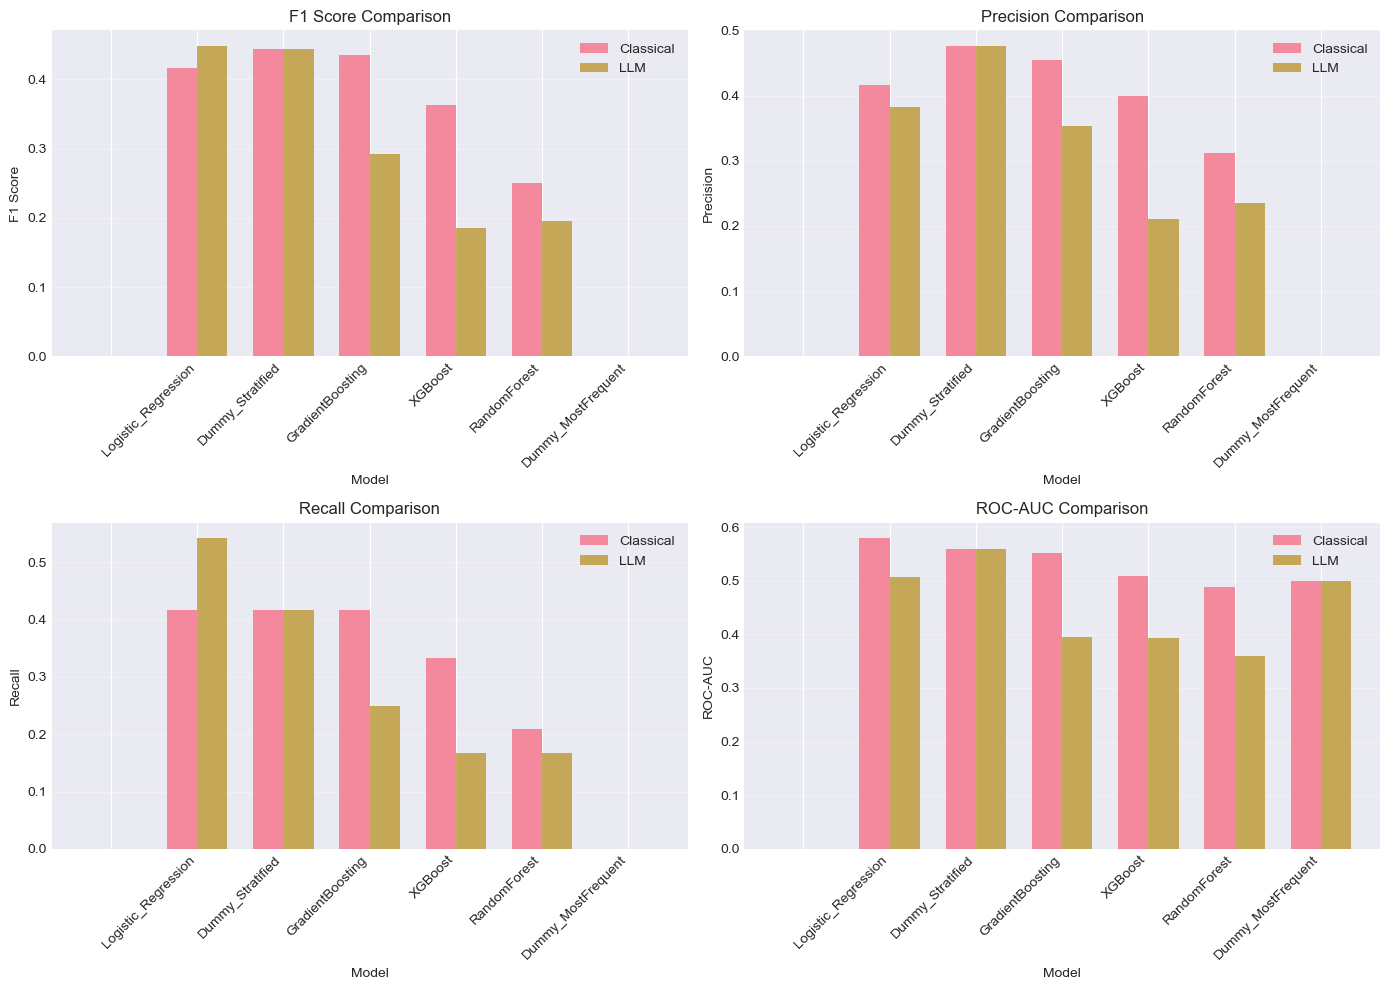


4. KEY INSIGHTS

  Winner: CLASSICAL features
  Average F1 difference: 0.079 (22.7%)

  Classical features (avg F1): 0.346
  LLM features (avg F1):       0.268

  Feature count:
    Classical: 47 features
    LLM:       14 features

✓ Experiment comparison complete


In [19]:
# ============================================================================
# COMPARE CLASSICAL VS LLM FEATURE SETS
# ============================================================================

print("="*60)
print("EXPERIMENT COMPARISON: CLASSICAL VS LLM")
print("="*60)

# Query MLflow for all runs in this experiment
experiment = mlflow.get_experiment_by_name("linkedin-lead-scoring")
all_runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Filter for runs with feature_set parameter (our dual experiments)
dual_exp_runs = all_runs[all_runs['params.feature_set'].notna()].copy()

if len(dual_exp_runs) == 0:
    print("\n⚠️  No dual experiment runs found yet. Run the model training cells first.")
else:
    # Extract key columns
    comparison_df = dual_exp_runs[[
        'tags.mlflow.runName',
        'params.model_type',
        'params.feature_set',
        'params.n_features_used',
        'metrics.test_f1',
        'metrics.test_precision',
        'metrics.test_recall',
        'metrics.test_roc_auc'
    ]].copy()
    
    # Rename columns for clarity
    comparison_df.columns = ['run_name', 'model', 'feature_set', 'n_features', 
                              'f1', 'precision', 'recall', 'roc_auc']
    
    # Sort by F1 score
    comparison_df = comparison_df.sort_values('f1', ascending=False)
    
    # Convert to numeric
    for col in ['n_features', 'f1', 'precision', 'recall', 'roc_auc']:
        comparison_df[col] = pd.to_numeric(comparison_df[col], errors='coerce')
    
    print(f"\n1. OVERALL RANKING (by F1 score)")
    print("="*60)
    print(comparison_df.to_string(index=False))
    
    # Group by feature set to compare
    print(f"\n2. COMPARISON BY FEATURE SET")
    print("="*60)
    
    feature_set_summary = comparison_df.groupby('feature_set').agg({
        'f1': ['mean', 'std', 'max'],
        'precision': 'mean',
        'recall': 'mean',
        'roc_auc': 'mean',
        'n_features': 'first'
    }).round(3)
    
    print(feature_set_summary)
    
    # Find best model for each feature set
    print(f"\n3. BEST MODEL PER FEATURE SET")
    print("="*60)
    
    for feature_set in ['classical_only', 'llm_only']:
        subset = comparison_df[comparison_df['feature_set'] == feature_set]
        if len(subset) > 0:
            best = subset.iloc[0]
            print(f"\n{feature_set.upper()}:")
            print(f"  Best model: {best['model']}")
            print(f"  F1 score:   {best['f1']:.3f}")
            print(f"  Precision:  {best['precision']:.3f}")
            print(f"  Recall:     {best['recall']:.3f}")
            print(f"  ROC-AUC:    {best['roc_auc']:.3f}")
            print(f"  # Features: {int(best['n_features'])}")
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    metrics_to_plot = ['f1', 'precision', 'recall', 'roc_auc']
    metric_names = ['F1 Score', 'Precision', 'Recall', 'ROC-AUC']
    
    for ax, metric, metric_name in zip(axes.flat, metrics_to_plot, metric_names):
        # Create grouped bar plot
        classical = comparison_df[comparison_df['feature_set'] == 'classical_only']
        llm = comparison_df[comparison_df['feature_set'] == 'llm_only']
        
        # Get unique models
        models = comparison_df['model'].unique()
        
        x = np.arange(len(models))
        width = 0.35
        
        classical_vals = [classical[classical['model'] == m][metric].values[0] 
                         if len(classical[classical['model'] == m]) > 0 else 0 
                         for m in models]
        llm_vals = [llm[llm['model'] == m][metric].values[0] 
                   if len(llm[llm['model'] == m]) > 0 else 0 
                   for m in models]
        
        ax.bar(x - width/2, classical_vals, width, label='Classical', alpha=0.8)
        ax.bar(x + width/2, llm_vals, width, label='LLM', alpha=0.8)
        
        ax.set_xlabel('Model')
        ax.set_ylabel(metric_name)
        ax.set_title(f'{metric_name} Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/tmp/feature_set_comparison.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    # Summary insights
    print(f"\n4. KEY INSIGHTS")
    print("="*60)
    
    classical_avg = comparison_df[comparison_df['feature_set'] == 'classical_only']['f1'].mean()
    llm_avg = comparison_df[comparison_df['feature_set'] == 'llm_only']['f1'].mean()
    
    if classical_avg > llm_avg:
        winner = "CLASSICAL"
        diff = classical_avg - llm_avg
    else:
        winner = "LLM"
        diff = llm_avg - classical_avg
    
    print(f"\n  Winner: {winner} features")
    print(f"  Average F1 difference: {diff:.3f} ({diff/max(classical_avg, llm_avg)*100:.1f}%)")
    print(f"\n  Classical features (avg F1): {classical_avg:.3f}")
    print(f"  LLM features (avg F1):       {llm_avg:.3f}")
    
    classical_n = int(comparison_df[comparison_df['feature_set'] == 'classical_only']['n_features'].iloc[0])
    llm_n = int(comparison_df[comparison_df['feature_set'] == 'llm_only']['n_features'].iloc[0])
    
    print(f"\n  Feature count:")
    print(f"    Classical: {classical_n} features")
    print(f"    LLM:       {llm_n} features")
    
    print("\n" + "="*60)
    print("✓ Experiment comparison complete")
    print("="*60)

## 11. Model Explainability with SHAP

**Understand what drives predictions**

In [ ]:
print("Generating SHAP explanations...\n")
print("⚠️  Using UNSCALED data for SHAP (same as model training)")

# Create SHAP explainer for best model
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for test set (sample for speed) - USE UNSCALED DATA
sample_size = min(100, len(X_test))
X_test_sample = X_test.sample(n=sample_size, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

print(f"✓ SHAP values calculated for {sample_size} test samples\n")

# End previous run if active (start new for SHAP artifacts)
if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run(run_name="SHAP_Explainability"):
    mlflow.log_param("model_explained", "XGBoost_Optimized")
    mlflow.log_param("shap_sample_size", sample_size)
    mlflow.log_param("data_type", "unscaled")
    
    # Summary plot (feature importance)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_sample, show=False)
    plt.tight_layout()
    plt.savefig('/tmp/shap_summary.png', dpi=100, bbox_inches='tight')
    mlflow.log_artifact('/tmp/shap_summary.png', 'explainability')
    plt.show()
    
    # Waterfall plot for first prediction
    plt.figure(figsize=(10, 8))
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=X_test_sample.iloc[0],
        feature_names=X_test_sample.columns.tolist()
    ), show=False)
    plt.tight_layout()
    plt.savefig('/tmp/shap_waterfall.png', dpi=100, bbox_inches='tight')
    mlflow.log_artifact('/tmp/shap_waterfall.png', 'explainability')
    plt.show()
    
    print("\n✓ SHAP explanations generated and logged to MLflow")
    print("✓ Used unscaled data (consistent with model training)")

## 12. Model Selection & Registration

**Register best model in MLflow Model Registry**

In [ ]:
# Query MLflow for best model
experiment = mlflow.get_experiment_by_name("linkedin-lead-scoring")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Filter for model training runs
model_runs = runs_df[
    runs_df['tags.mlflow.runName'].str.contains('tree_|baseline_|Optuna', na=False)
]

# Sort by F1 score
best_run = model_runs.sort_values('metrics.test_f1', ascending=False).iloc[0]

print("Best Model Selection:")
print(f"  Model: {best_run['tags.mlflow.runName']}")
print(f"  Run ID: {best_run['run_id']}")
print(f"  Test F1: {best_run['metrics.test_f1']:.3f}")
print(f"  Test Precision: {best_run['metrics.test_precision']:.3f}")
print(f"  Test Recall: {best_run['metrics.test_recall']:.3f}")
print(f"  Test ROC-AUC: {best_run['metrics.test_roc_auc']:.3f}")

# Register model
model_uri = f"runs:/{best_run['run_id']}/model"
model_name = "linkedin-lead-scorer"

try:
    model_version = mlflow.register_model(model_uri, model_name)
    
    print(f"\n✓ Model registered: '{model_name}' version {model_version.version}")
    
    # Transition to Production (optional - can also do manually in UI)
    # client = mlflow.tracking.MlflowClient()
    # client.transition_model_version_stage(
    #     name=model_name,
    #     version=model_version.version,
    #     stage="Production"
    # )
    # print(f"✓ Model transitioned to Production stage")
    
except Exception as e:
    print(f"\nℹ️  Model registration note: {e}")
    print("   (Model may already be registered - check MLflow UI)")

print(f"\n✓ Model selection complete")
print(f"\nView in MLflow UI: http://localhost:5000")
print(f"  → Navigate to 'Models' tab to see registered model")

## 13. Summary & Next Steps

In [ ]:
print("="*60)
print("MODEL TRAINING SUMMARY")
print("="*60)
print(f"\nDataset:")
print(f"  Total samples: {len(df):,}")
print(f"  Train: {len(X_train):,} samples")
print(f"  Test:  {len(X_test):,} samples")
print(f"\nModels trained: {len(all_results)}")
print(f"  Baseline: {len(baseline_results)}")
print(f"  Tree-based: {len(tree_results)}")
print(f"  Optimized: 1 (XGBoost with Optuna)")
print(f"\nBest Model:")
print(f"  Name: {best_run['tags.mlflow.runName']}")
print(f"  Test F1: {best_run['metrics.test_f1']:.3f}")
print(f"  Test Precision: {best_run['metrics.test_precision']:.3f}")
print(f"  Test Recall: {best_run['metrics.test_recall']:.3f}")
print(f"  Test ROC-AUC: {best_run['metrics.test_roc_auc']:.3f}")
print(f"\nMLflow:")
print(f"  Experiment: linkedin-lead-scoring")
print(f"  Registered model: {model_name}")
print(f"  MLflow UI: http://localhost:5000")
print(f"\n" + "="*60)
print("✓ Model training complete!")
print("Next steps:")
print("  1. Review model performance in MLflow UI")
print("  2. Analyze SHAP explanations for insights")
print("  3. Consider feature engineering enhancements")
print("  4. Deploy model via FastAPI endpoint")
print("="*60)

## 14. Clean Up

In [ ]:
# End MLflow run
if mlflow.active_run():
    mlflow.end_run()

print("✓ All MLflow runs ended")
print(f"\nView all results at: http://localhost:5000")